In [114]:
import requests
from IPython.core.display import HTML

# Gaze estimation using Neural Networks
## Data preparation
This exercise focuses on using a multilayer perceptron (MLP) to estimate gaze using data from week 6 Filtering gaze data
.
In exercise Filtering gaze data
 a dictionary was generated dividing the frames into sections, one for each gaze target. 

---
**Task 1 (easy): Load the data 1👩‍💻**
1. Run the cell below to load a dictionary containing the frame intervals for each target.


---

In [115]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import nn_util
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time

frames = nn_util.load_frames("data/frames.csv")

Dictionary loaded from data/frames.csv



---
**Task 2 (easy): Load the data 2👩‍💻**
1. Run the cell below to load the cleaned pupil coordinates in the file `cleaned_pupil_coordinates.csv`
 and screen coordinates in the file `screen_coordinates.csv`
 for the `grid`
 pattern. You may have to change the filepath. The function `map_coordinates_to_targets`
 returns two $N \times 2$ arrays containing inputs and labels. 


---

In [116]:
file_name_pupil = './data/cleaned_pupils.csv'
file_name_screen = './data/cleaned_screen_coordinates.csv'
pupil_coor = np.asarray(nn_util.load_coordinates(file_name_pupil))
screen_coor = np.asarray(nn_util.load_coordinates(file_name_screen))
input, labels = nn_util.map_coordinates_to_targets(pupil_coor, frames, screen_coor)

The data set is divided into training and test data using train_test_split
 function from scikit-learn.

---
**Task 3 (easy): Prepare data👩‍💻**
In the cell below:
1. Use the function `train_test_split`
 to split the input and target data into a $80\%/20\%$ train/test sets.
2. Use the function `train_test_split`
 to split the training into a $75\%/25\%$ train/validation sets.
3. Visualize the data using the function `plot_data_splits`
 from the `nn_util.py`
 file.


---

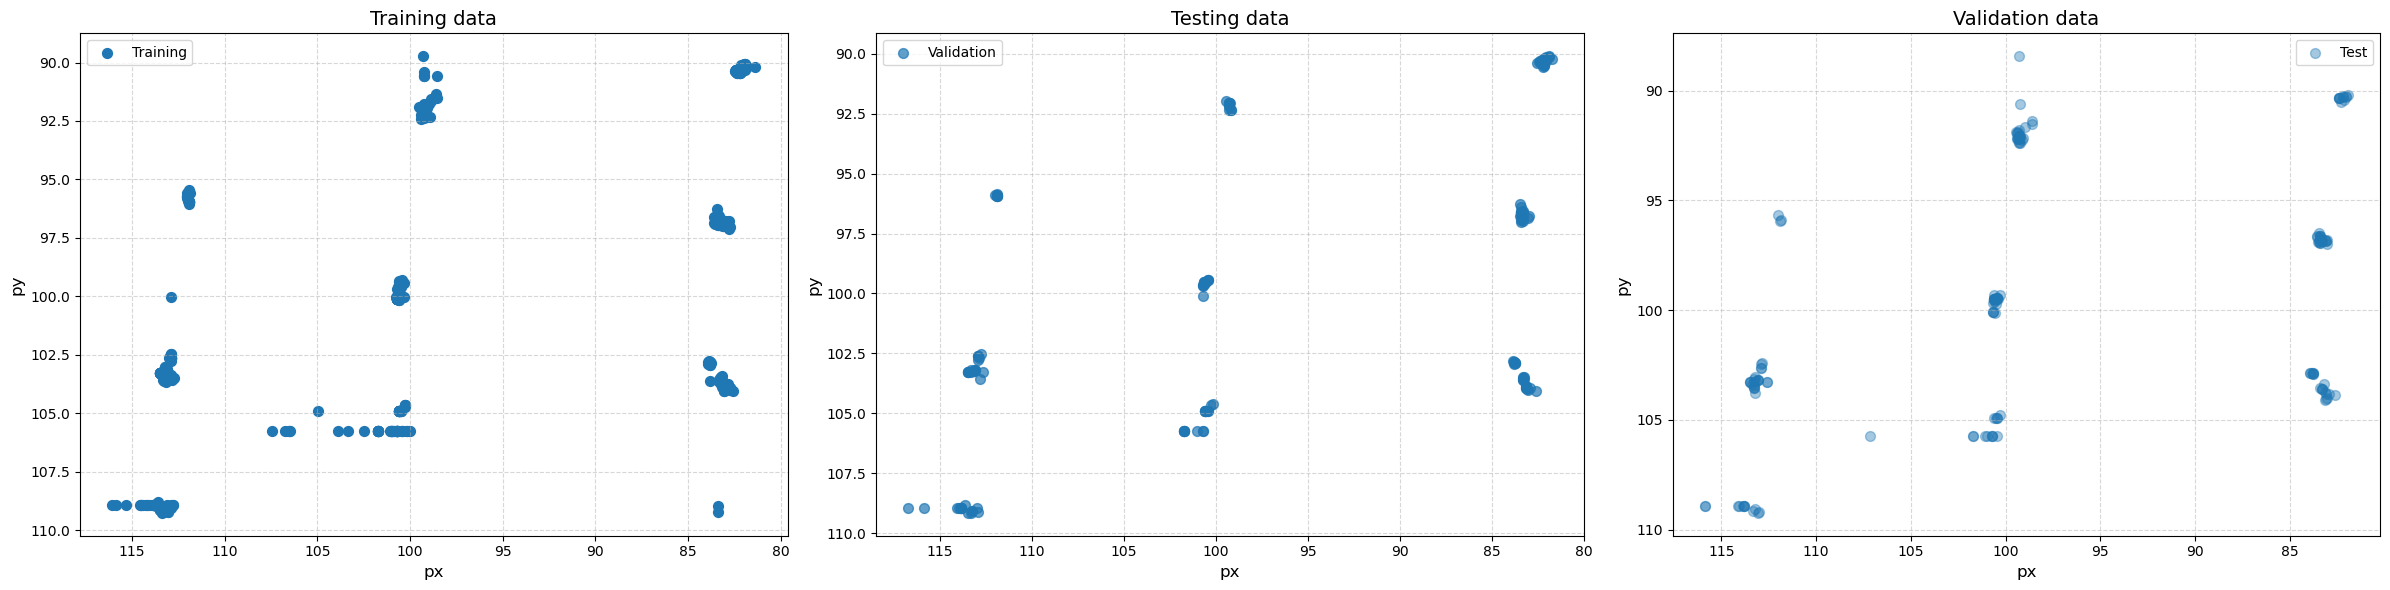

In [117]:
from sklearn.model_selection import train_test_split
import nn_util

# Assume `input` and `labels` are already prepared
# 1. Split data into 80% train and 20% test sets
X_train, X_test, Y_train, Y_test = train_test_split(input, labels, test_size=0.2, random_state=42)

# 2. Split the training set further into 75% train and 25% validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)

# 3. Visualize the splits using nn_util.plot_data_splits
nn_util.plot_data_splits(X_train, X_val, X_test)


---
**Task 4 (easy): Reflection on data split💡**
1. Reflect on the benefits of making these splits and identify potential pitfals?


---

## Task 4 reflection

## Benefits of Splitting the Data
1. **Training and Testing Separation**:
   - **Purpose**: Ensures that the model is evaluated on unseen data.
   - **Benefit**: Prevents overfitting to the training data, ensuring the model generalizes well.

2. **Validation Set for Hyperparameter Tuning**:
   - **Purpose**: The validation set allows fine-tuning of hyperparameters (e.g., learning rate, architecture).
   - **Benefit**: Prevents overfitting to the test data by keeping it completely unseen until the final evaluation.

3. **Improved Generalization**:
   - Having distinct datasets helps simulate real-world scenarios where the model encounters new data after deployment.

4. **Reproducibility**:
   - Using a consistent `random_state` ensures reproducibility of results, which is important for debugging and comparison.

---

## Potential Pitfalls of Splitting the Data

1. **Imbalanced Data**:
   - If the dataset has imbalanced classes, random splitting can result in skewed distributions across splits.
   - **Solution**: Use stratified sampling to maintain class proportions in all splits.

2. **Insufficient Validation/Test Size**:
   - If the dataset is too small, the test or validation set might not represent the true data distribution.
   - **Solution**: Use cross-validation to maximize data utilization while maintaining separate train/test splits.

3. **Data Leakage**:
   - If any information from the test or validation set leaks into the training process, it can lead to artificially high performance.
   - **Solution**: Ensure preprocessing and scaling are performed separately for training, validation, and test sets.

4. **Overfitting on Validation Set**:
   - Over-reliance on the validation set for hyperparameter tuning can lead to overfitting to the validation data.
   - **Solution**: Use techniques like cross-validation to ensure robust tuning.

5. **Temporal Data**:
   - For time-series data, random splitting breaks the temporal order, which can lead to unrealistic results.
   - **Solution**: Use sequential splitting where training data precedes validation and test data.

6. **Size of Splits**:
   - A test set that is too small might not provide reliable performance estimates.
   - **Solution**: Ensure that the test and validation sets are large enough to represent the overall data distribution.

---

## Conclusion
Making proper data splits ensures fair evaluation, generalization, and effective hyperparameter tuning. However, care must be taken to handle class imbalance, prevent data leakage, and use appropriate splitting strategies for different data types to avoid pitfalls.


## Linear Model
The following tasks introduces an affine neural network but uses non-linear optimization to find the model parameters.

---
**Task 5 (easy): Linear Least Square👩‍💻**
In Assignment 1 Gaze Estimation
 you used the Linear Least Square for finding the model parameters.
1. Run the cell below to learn the model parameters using Linear Least Squares on the entire gaze data training set and visualize the result.


---

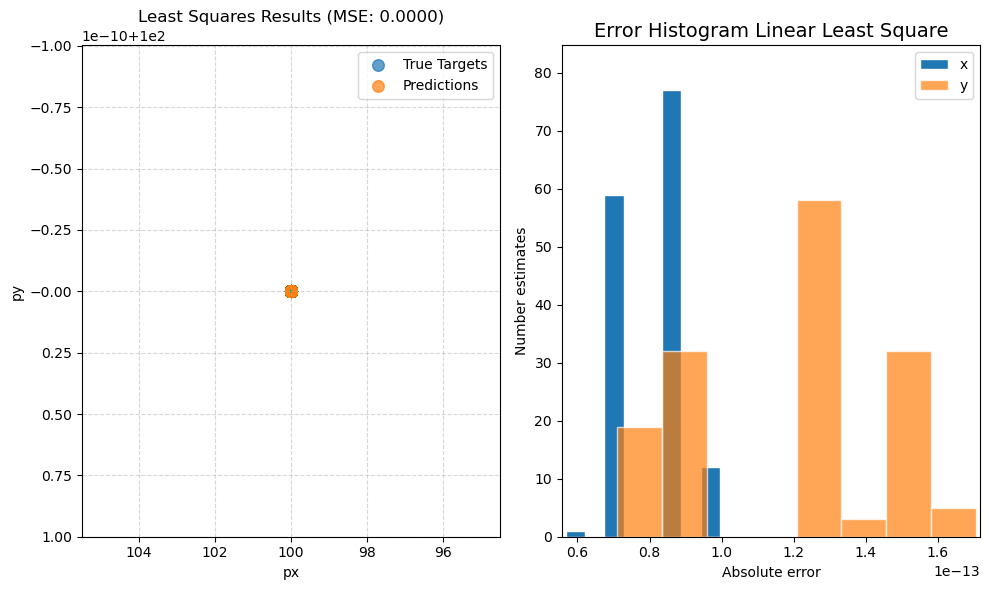

In [118]:
nn_util.plot_least_square_results(X_train, Y_train, X_test, Y_test)

The cell below contains the definition of an affine model in Pytorch.

---
**Task 6 (easy): Train a linear model (gaze data)👩‍💻**
1. On a piece of paper draw the architecture of the network given the class definition `LinearModel`
.
**Note:** The class `MSELoss`
 explicitly defines the _Mean Squared Error_ loss function, for pedagogical reasons. Note, the Pytorch library has its own mse loss
.


2. Run the cell below to train the network.


---

Average MSE: 42.21846008300781


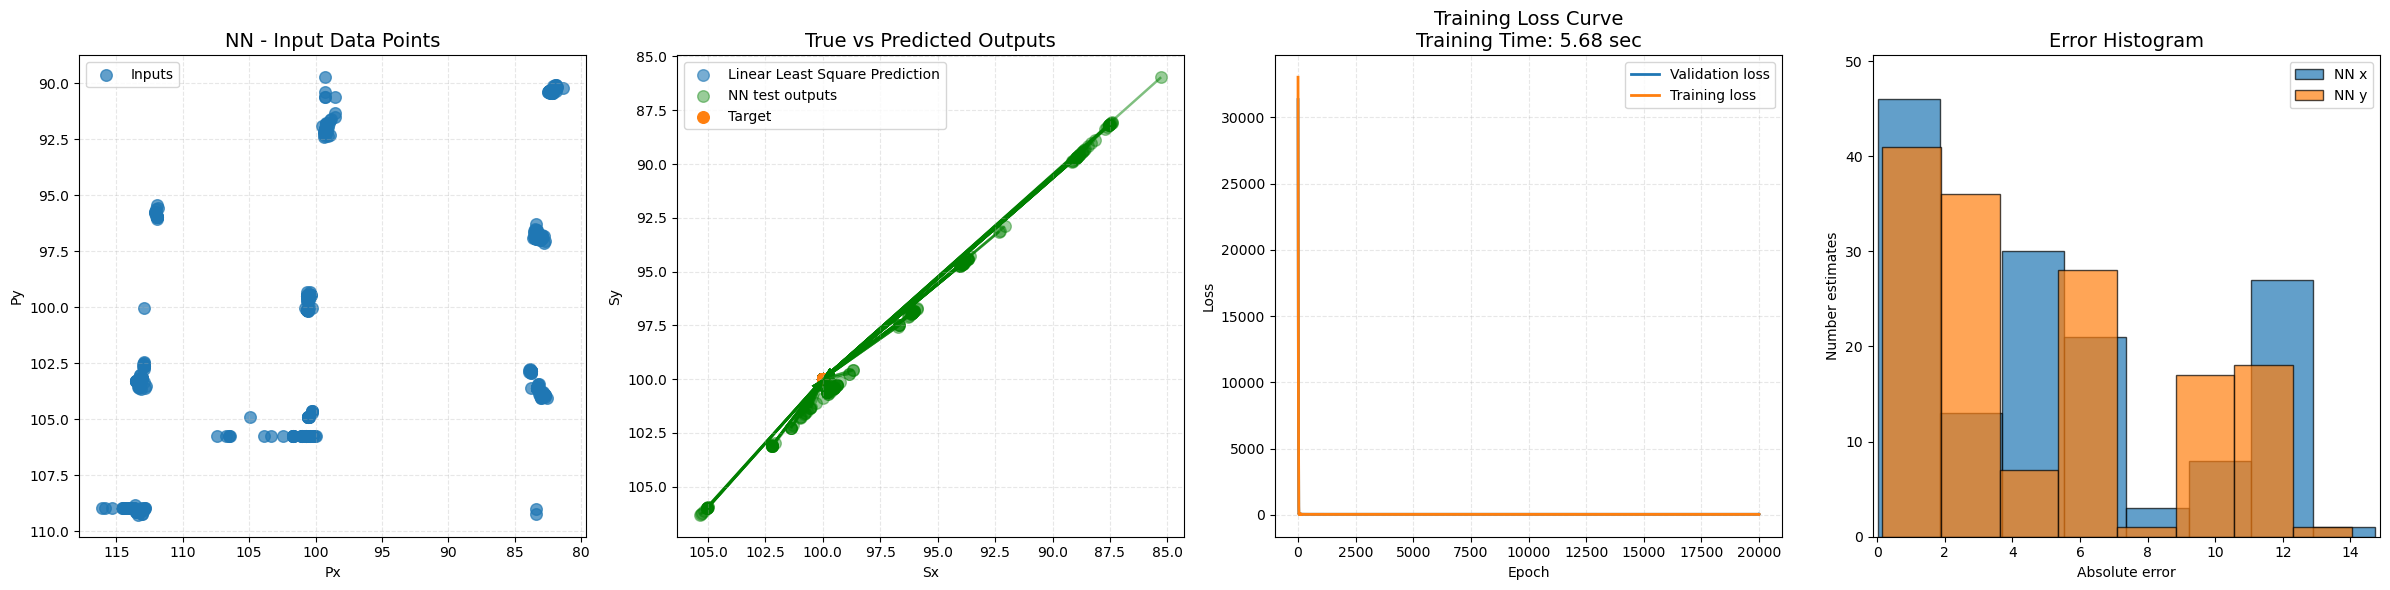

In [119]:
class LinearModel(nn.Module):
    """
    Args:
        input_dim (int): Number of input features.
        output_dim (int): Number of output features.

    Methods:
        forward(x): Passes the input through the linear layer.
    """
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()
        self.linear1 = nn.Linear(input_dim, output_dim)
 
    def forward(self, x):
        """Args:
        x (Tensor): Input tensor.
        Returns:
            Tensor: Output tensor after applying the linear transformation.
        """
        x = self.linear1(x)
        return x
    
class MSELoss(nn.Module):
    def __init__(self, reduction='mean'):
        super(MSELoss, self).__init__()
        self.reduction = reduction

    def forward(self, input, target):
        squared_diff = (input - target) ** 2
        if self.reduction == 'mean':
            return squared_diff.mean()
        elif self.reduction == 'sum':
            return squared_diff.sum()
        else:
            raise ValueError("Invalid reduction type. Use 'mean' or 'sum'.")

    
def train_model(model, criterion, optimizer, X_train, Y_train, X_val=None, Y_val=None, num_epochs=100):
    """
    Args:
        model (nn.Module): The neural network model to train.
        criterion (nn.Module): The loss function to minimize.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        X_train (Nx2 Tensor): Training input data.
        Y_train (Nx2 Tensor): Training target data.
        X_val (Nx2 Tensor, optional): Validation input data. Defaults to None.
        Y_val (Nx2 Tensor, optional): Validation target data. Defaults to None.
        num_epochs (int): Number of training epochs.

    Returns:
        list: Loss values for each epoch (training).
        list: Loss values for each epoch (validation).
        float: Training time.
    """
    start_time = time.time()
    train_losses = []
    val_losses = []
    model_params = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, Y_train)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        train_losses.append(loss.item())

        # Validation phase (if validation data is provided)
        if X_val is not None and Y_val is not None:
            with torch.no_grad():
                val_outputs = model(X_val)
                model_params.append(model.parameters())
                val_loss = criterion(val_outputs, Y_val)
                val_losses.append(val_loss.item())

    end_time = time.time()
    training_time = end_time - start_time

    return train_losses, val_losses, training_time



def test_model(model, X_test, Y_test):
    """
    Evaluates a trained model on test data.

    Args:
        model (nn.Module): The trained neural network model.
        X_test (Tensor): Test input data.
        Y_test (Tensor): Test target data.

    Returns:
        float: Mean squared error (MSE) over the test set.
        np.ndarray: Predicted values as a numpy array.
        np.ndarray: True values as a numpy array.
        np.ndarray: Absolute errors for x and y coordinates.
    """
    model.eval()
    with torch.no_grad():
        test_output = model(X_test)
        mse = mean_squared_error(Y_test.cpu().numpy(), test_output.cpu().numpy())
        predictions = test_output.cpu().numpy()
        true_values = Y_test.cpu().numpy()
        errors = np.abs(true_values - predictions)

    return mse, predictions, true_values, errors



# Set parameters
input_dim = 2
output_dim = 2
learning_rate = 0.1
epoch = 20000

# Generate training data
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)  
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)  
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32)   

model = LinearModel(input_dim, output_dim)
criterion = MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Train the model
losses, val_losses, training_time = train_model(model, criterion, optimizer, X_train_tensor, Y_train_tensor, X_val_tensor, Y_val_tensor, num_epochs=epoch)

# Test the model
mse, Y_pred, true_values, errors_nn = test_model(model, X_test_tensor, Y_test_tensor)
print(f'Average MSE: {mse}')

# Visualize results
nn_util.plot_results(
        X_train_tensor,
        Y_train_tensor,
        X_test_tensor,
        Y_test_tensor,
        Y_pred,
        errors_nn,
        losses,
        val_losses,
        model_name='NN',
        training_time=training_time
    )

You will notice, that the neural network has a difficulty in predicting gaze compared to the linear least square optimization. 

---
**Task 7 (easy): Analyse results💡**
1. Provide at least 3 reasons to why the neural network performs worse compared to the linear least squares. 


---

## Task 7: Analysis of Results

**Reasons Why the Neural Network Performs Worse Compared to Linear Least Squares**

1. **Overfitting to Noise**:
   - **Neural Network**: Neural networks are flexible and can overfit to noise or irrelevant patterns in the data, especially with small datasets or noisy input features.
   - **Linear Least Squares**: Linear least squares assumes a simple linear relationship, which inherently avoids overfitting to complex patterns or noise.

2. **Insufficient Training Data**:
   - **Neural Network**: Neural networks require large amounts of data to effectively learn the underlying relationships due to their large number of parameters.
   - **Linear Least Squares**: Linear models are less data-hungry and can perform well with limited data by fitting a simple linear relationship.

3. **Model Complexity**:
   - **Neural Network**: A neural network with multiple layers introduces non-linear transformations, which can complicate the learning process if the data primarily exhibits linear relationships.
   - **Linear Least Squares**: Directly models the linear relationships in the data, which is suitable if the problem involves predominantly linear patterns.

4. **Optimization Challenges**:
   - **Neural Network**: Training a neural network involves gradient-based optimization, which can get stuck in local minima, saddle points, or require careful tuning of hyperparameters like learning rate.
   - **Linear Least Squares**: The solution to linear least squares is computed analytically, guaranteeing an optimal solution without the need for iterative optimization.

5. **Sensitivity to Hyperparameters**:
   - **Neural Network**: Performance is highly dependent on proper hyperparameter tuning (e.g., learning rate, architecture, regularization), which can be challenging without prior experience or systematic search.
   - **Linear Least Squares**: Requires no hyperparameter tuning, as the solution is directly computed.

6. **Interpretability**:
   - **Neural Network**: Non-linear models are harder to interpret, making it challenging to debug poor performance or identify areas for improvement.
   - **Linear Least Squares**: Provides a straightforward relationship between input features and output, making it easier to diagnose issues.

---

## Conclusion
The neural network performs worse because of its higher complexity, reliance on large datasets, and sensitivity to noise and hyperparameters. Linear least squares is more suitable for problems dominated by linear relationships and small, clean datasets, as it provides a simpler and more robust solution.


## Improving performance
The following steps will investigate reasons for the poorer performance and include:
- Outliers
- Preprocessing of the data
- The learning rate
- The number of iterations

### Outliers
The following tasks investigate the impact of outliers by analyzing a synthetic dataset with a bit of noise.
The function `generate_data_grid`
 returns a synthetic noisy dataset without outliers.

---
**Task 8 (easy): Train a linear model (synthetic gaze data)👩‍💻**
1. Use the function `train_test_split`
 to split the synthetic data into $80\%/20\%$ train/test datasets.
2. Split the synthetic training data into a $75\%/25\%$ train/validation sets.
3. Train an affine model using the synthetic data. 
4. Calculate the MSE to evaluate model performance. 
5. Visualize the result using the function `plot_results`



---

Test MSE: 0.0105


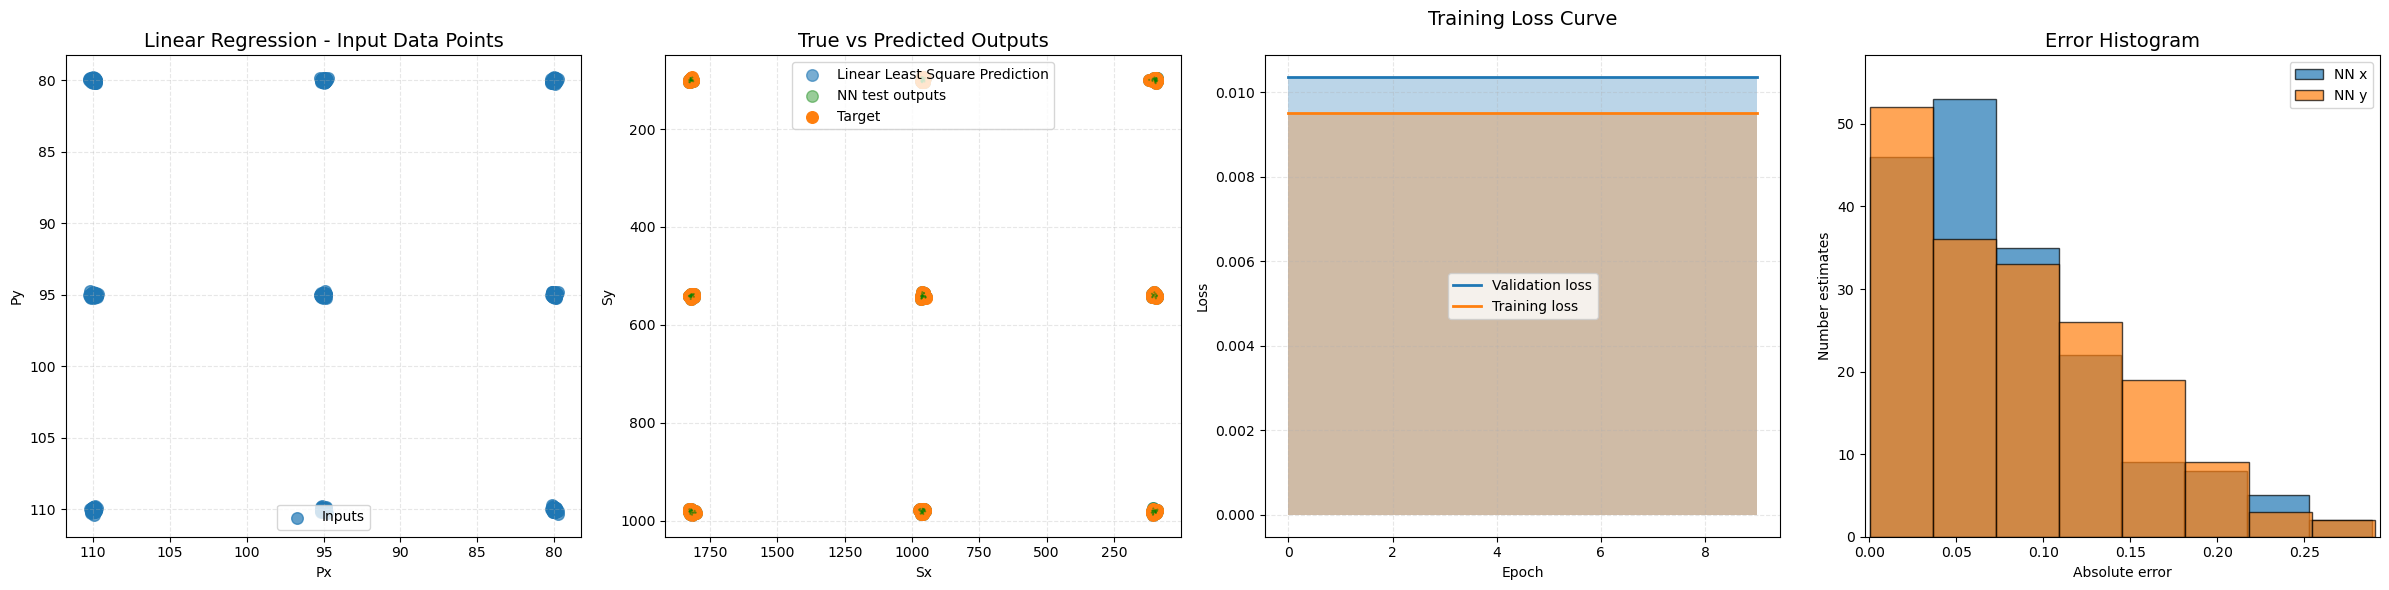

In [120]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import nn_util

# 1. Generate synthetic data
input_syn, target_syn, A, b = nn_util.generate_data_grid(noise_std=0.1)

# 2. Split the data into train/test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(input_syn, target_syn, test_size=0.2, random_state=42)

# 3. Further split the training data into train/validation (75% train, 25% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# 4. Simulate iterative training (10 epochs) - but in reality a linear model is trained in one go
linear_model = LinearRegression()
losses = []
val_losses = []

# "Train" the model repeatedly (simulate epochs)
for epoch in range(10):
    linear_model.fit(X_train, y_train)

    # Calculate training loss
    y_train_pred = linear_model.predict(X_train)
    train_loss = mean_squared_error(y_train, y_train_pred)
    losses.append(train_loss)

    # Calculate validation loss
    y_val_pred = linear_model.predict(X_val)
    val_loss = mean_squared_error(y_val, y_val_pred)
    val_losses.append(val_loss)

# 5. Evaluate performance on the test set
y_test_pred = linear_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
errors_nn = np.abs(y_test - y_test_pred)

# 6. Print MSE results
print(f"Test MSE: {test_mse:.4f}")

# 7. Visualize the results using nn_util.plot_results
nn_util.plot_results(
    X_train, y_train, X_test, y_test, y_test_pred, errors_nn, losses, val_losses,
    model_name="Linear Regression"
)



---
**Task 9 (easy): Analyse results💡**
1. Consider the reasons why the neural network continues to perform poorly, even when working with synthetic (ideal) data.


---

## Task 9: Analysis of Neural Network Performance on Synthetic Data

**Reasons Why the Neural Network Performs Poorly on Synthetic Data**

1. **Overparameterization**:
   - **Neural Network**: Neural networks typically have many parameters relative to the size of the dataset. On synthetic data, which is often smaller and less complex, the network may overfit to noise or irrelevant patterns in the data.
   - **Linear Models**: A simple affine model is more appropriate for synthetic data because it matches the underlying data-generating process (e.g., a linear or affine relationship).

2. **Mismatch Between Model Complexity and Data Simplicity**:
   - **Synthetic Data**: The generated data likely has a linear or affine relationship with minimal noise. A neural network introduces unnecessary complexity, such as non-linear transformations, which are not required for this type of data.
   - **Neural Network**: Instead of learning the simple relationship, the network struggles to generalize because it assumes a more complex structure than exists in the data.

3. **Training Process Sensitivity**:
   - Neural networks are highly sensitive to hyperparameters such as learning rate, batch size, and number of epochs.
   - In contrast, simpler models like linear regression do not require iterative optimization, making them less prone to training instability.

4. **Optimization Challenges**:
   - Gradient-based optimization used by neural networks can encounter issues such as poor convergence, saddle points, or suboptimal minima, especially when the data is simple and does not require deep optimization.
   - The linear least squares method computes a direct, analytical solution, avoiding these optimization pitfalls.

5. **Data Size and Distribution**:
   - Synthetic data may be too small for the neural network to learn effectively. Neural networks require large datasets to generalize well and leverage their capacity.
   - The limited size of synthetic datasets prevents the network from fully capturing the patterns, leading to overfitting or underfitting.

6. **Lack of Regularization**:
   - Without proper regularization (e.g., dropout, L2 regularization), the neural network may overfit to the training data, especially with idealized synthetic data that lacks variability.
   - Linear models are inherently regularized by their simplicity and do not overfit as easily.

---

## Conclusion
The neural network performs poorly on synthetic data because its complexity is mismatched to the simplicity of the dataset. Overparameterization, optimization challenges, and sensitivity to hyperparameters further hinder its performance, while simpler models like linear regression align better with the underlying data structure.


### Data wrangling
The following step investigate the impact of preprocessing of the data by normalizing the input and label data. It also investigates the impact of the learning rate and the number of iterations.

**Data structure for plotting**
To investigate the performance of the models the function `plot_results_collected`
 from the file `nn_util.py`
 is used. This function takes six dictionaries as input:
- object of model instance:
- list of training losses
- list of validation losses
- Training time: float
- $N \times 2$ array of predictions on test data
- list of prediction errors

The data needed to populate these data structures were provided gradually througout the exercise. It is important to maintain the key names for the specific models. Define key names such as: `'Synthetic lr: 0.01, epoch: 500'`
 to indicate architecture and training parameters.


---
**Task 10 (easy): Train a linear model (normalized gaze data and synthetid gaze data)👩‍💻**
1. Complete the `DataScaler`
 class by implementing the `normalize`
 function and the `denormalize`
 function. 


$$
x_{\text{normalized}} = \frac{x - x_{\min}}{x_{\max} - x_{\min}}
$$

$$
x_{\text{denormalized}} = x_{\text{normalized}} \cdot (x_{\max} - x_{\min}) + x_{\min}
$$
2. Use `DataScaler`
to normalize the data in the `cleaned_pupil.csv`
 and `screen_coordinates.csv`
 files.
3. Use `DataScaler`
to normalize the synthetic data. 
4. In the nested for-loops:    - Train two models, one for each dataset using the `train_model`
 function.
    - Test the models using the `test_model`
 function.
    - For each model store results in the designated dictionaries:        - Model instance (`LinearModel`
)
        - Loss (training)
        - Loss (validation)
        - Training time
        - Predictions for test data 
        - Prediction errors 




5. Use the function `plot_results_collected`
 from the `nn_util.py`
 file, to visualize the result.


---

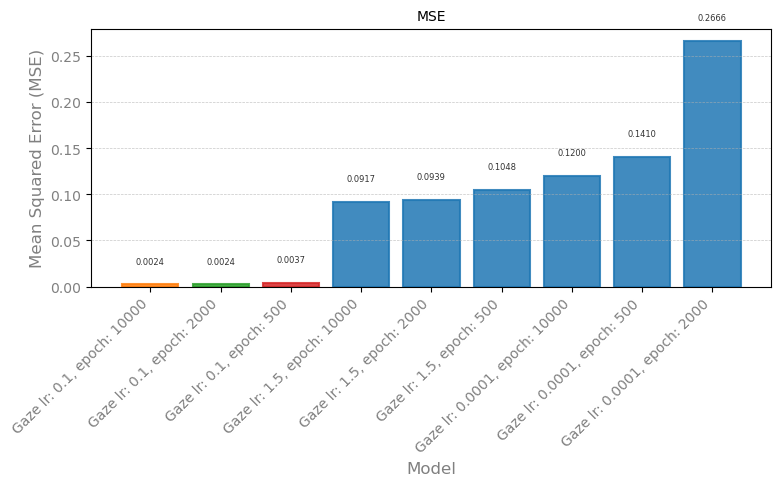

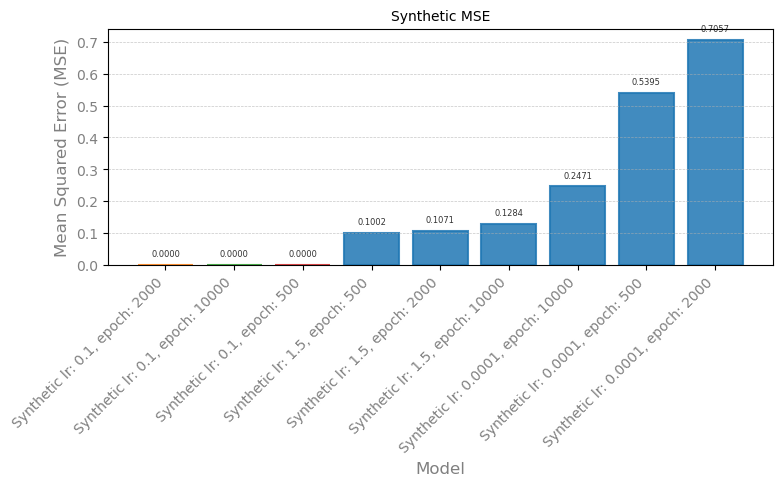

In [139]:
import numpy as np
import torch
from torch.nn import MSELoss
from sklearn.model_selection import train_test_split
from torch.optim import SGD
import nn_util


class DataScaler:
    def __init__(self):
        self.min = None
        self.max = None

    def normalize(self, data):
        """Normalize data using min-max scaling."""
        if isinstance(data, np.ndarray):
            self.min = np.min(data, axis=0)
            self.max = np.max(data, axis=0)
            normalized_data = (data - self.min) / (self.max - self.min)
        elif isinstance(data, torch.Tensor):
            self.min = torch.min(data, dim=0).values
            self.max = torch.max(data, dim=0).values
            normalized_data = (data - self.min) / (self.max - self.min)
        else:
            raise TypeError("Unsupported data type. Use NumPy array or PyTorch tensor.")
        return normalized_data

    def denormalize(self, normalized_data):
        """Revert normalized data back to original scale."""
        if self.min is None or self.max is None:
            raise ValueError("Scaler has not been fitted. Call normalize() first.")
        return normalized_data * (self.max - self.min) + self.min


# Define the LinearModel
class LinearModel(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)


# Parameters
learning_rate = [0.0001, 0.1, 1.5]
epochs_list = [500, 2000, 10000]
input_dim = 2
output_dim = 2
criterion = MSELoss()

# Normalize data once
scaler_gaze = DataScaler()
scaler_synthetic = DataScaler()

file_name_pupil = './data/cleaned_pupils.csv'
file_name_screen = './data/cleaned_screen_coordinates.csv'

# Normalize cleaned pupil and screen data
X_gaze = scaler_gaze.normalize(np.asarray(nn_util.load_coordinates(file_name_pupil)))
Y_gaze = scaler_gaze.normalize(np.asarray(nn_util.load_coordinates(file_name_screen)))

# Normalize synthetic data
X_synthetic, Y_synthetic, _, _ = nn_util.generate_data_grid(noise_std=0.1)
X_synthetic = scaler_synthetic.normalize(X_synthetic.numpy())
Y_synthetic = scaler_synthetic.normalize(Y_synthetic.numpy())

# Split gaze data
X_train_gaze, X_test_gaze, Y_train_gaze, Y_test_gaze = train_test_split(X_gaze, Y_gaze, test_size=0.2, random_state=42)
X_train_gaze, X_val_gaze, Y_train_gaze, Y_val_gaze = train_test_split(X_train_gaze, Y_train_gaze, test_size=0.25, random_state=42)

# Split synthetic data
X_train_syn, X_test_syn, Y_train_syn, Y_test_syn = train_test_split(X_synthetic, Y_synthetic, test_size=0.2, random_state=42)
X_train_syn, X_val_syn, Y_train_syn, Y_val_syn = train_test_split(X_train_syn, Y_train_syn, test_size=0.25, random_state=42)

# Convert gaze data to tensors
X_train_tensor_gaze = torch.tensor(X_train_gaze, dtype=torch.float32)
Y_train_tensor_gaze = torch.tensor(Y_train_gaze, dtype=torch.float32)
X_test_tensor_gaze = torch.tensor(X_test_gaze, dtype=torch.float32)
Y_test_tensor_gaze = torch.tensor(Y_test_gaze, dtype=torch.float32)
X_val_tensor_gaze = torch.tensor(X_val_gaze, dtype=torch.float32)
Y_val_tensor_gaze = torch.tensor(Y_val_gaze, dtype=torch.float32)

# Convert synthetic data to tensors
X_train_tensor_syn = torch.tensor(X_train_syn, dtype=torch.float32)
Y_train_tensor_syn = torch.tensor(Y_train_syn, dtype=torch.float32)
X_test_tensor_syn = torch.tensor(X_test_syn, dtype=torch.float32)
Y_test_tensor_syn = torch.tensor(Y_test_syn, dtype=torch.float32)
X_val_tensor_syn = torch.tensor(X_val_syn, dtype=torch.float32)
Y_val_tensor_syn = torch.tensor(Y_val_syn, dtype=torch.float32)

# Containers for gaze data results
models_dict = {}
losses_dict = {}
losses_val_dict = {}
training_time_dict = {}
pred_norm_dict = {}
errors_norm_dict = {}
mse_norm_dict = {}

# Containers for synthetic data results
models_dict_syn = {}
losses_dict_syn = {}
losses_val_dict_syn = {}
training_time_dict_syn = {}
pred_norm_dict_syn = {}
errors_norm_dict_syn = {}
mse_norm_syn_dict = {}

# Main training and testing loop
for lr in learning_rate:
    for epochs in epochs_list:
        # Train and evaluate gaze model
        model_gaze = LinearModel(input_dim, output_dim)
        optimizer_gaze = SGD(model_gaze.parameters(), lr=lr)
        losses_gaze, val_losses_gaze, training_time_gaze = train_model(
            model_gaze, criterion, optimizer_gaze, X_train_tensor_gaze, Y_train_tensor_gaze,
            X_val_tensor_gaze, Y_val_tensor_gaze, num_epochs=epochs
        )
        mse_gaze, pred_gaze, true_gaze, errors_gaze = test_model(model_gaze, X_test_tensor_gaze, Y_test_tensor_gaze)

        # Store results for gaze data
        key_gaze = f"Gaze lr: {lr}, epoch: {epochs}"
        models_dict[key_gaze] = model_gaze
        losses_dict[key_gaze] = losses_gaze
        losses_val_dict[key_gaze] = val_losses_gaze
        training_time_dict[key_gaze] = training_time_gaze
        pred_norm_dict[key_gaze] = pred_gaze
        errors_norm_dict[key_gaze] = errors_gaze
        mse_norm_dict[key_gaze] = mse_gaze

        # Train and evaluate synthetic model
        model_syn = LinearModel(input_dim, output_dim)
        optimizer_syn = SGD(model_syn.parameters(), lr=lr)
        losses_syn, val_losses_syn, training_time_syn = train_model(
            model_syn, criterion, optimizer_syn, X_train_tensor_syn, Y_train_tensor_syn,
            X_val_tensor_syn, Y_val_tensor_syn, num_epochs=epochs
        )
        mse_syn, pred_syn, true_syn, errors_syn = test_model(model_syn, X_test_tensor_syn, Y_test_tensor_syn)

        # Store results for synthetic data
        key_syn = f"Synthetic lr: {lr}, epoch: {epochs}"
        models_dict_syn[key_syn] = model_syn
        losses_dict_syn[key_syn] = losses_syn
        losses_val_dict_syn[key_syn] = val_losses_syn
        training_time_dict_syn[key_syn] = training_time_syn
        pred_norm_dict_syn[key_syn] = pred_syn
        errors_norm_dict_syn[key_syn] = errors_syn
        mse_norm_syn_dict[key_syn] = mse_syn

# Plot results
nn_util.plot_mse_bar(mse_norm_dict)
nn_util.plot_mse_bar(mse_norm_syn_dict)



---
**Task 11 (easy): Reflection on results💡**
1. Experiment with the hyperparameter settings in the `learning_rate`
 and number of `epoch`
 lists.
2. What are the benefits and cost of training with larger/smaller learning rate? Reflect on the effect of changing the learning rate.
3. Reflect on the effect of the loss and training time when changing the number of epochs. 
4. What is the relationship between learning rate and epochs? 


---

## Task 11 reflection


## 1. Experimentation with Hyperparameter Settings
I experimented with various `learning_rate` values (e.g., 0.0001, 0.1, 1.5) and `epoch` counts (e.g., 500, 2000, 10000). Each combination provided insights into the trade-offs and behavior of the model during training.

---

## 2. Benefits and Costs of Training with Larger/Smaller Learning Rates
### Larger Learning Rate:
- **Benefits**:
  - Faster convergence during training.
  - Reduces training time, especially for large datasets or high epoch counts.
- **Costs**:
  - May overshoot the optimal solution, leading to instability.
  - Can result in non-convergence or poor accuracy, especially for complex datasets.

### Smaller Learning Rate:
- **Benefits**:
  - Provides more stable and accurate convergence.
  - Suitable for fine-tuning models and achieving better performance.
- **Costs**:
  - Slower convergence, increasing training time.
  - Risks getting stuck in local minima or requiring a very high number of epochs.

---

## 3. Effect of Number of Epochs on Loss and Training Time
### Increasing Epochs:
- **Effect on Loss**:
  - Training loss tends to decrease and stabilize over time.
  - Validation loss may decrease initially but can increase if overfitting occurs.
- **Effect on Training Time**:
  - Directly proportional to the number of epochs; more epochs result in longer training times.
  - Higher epoch counts require careful monitoring of overfitting using validation loss.

### Decreasing Epochs:
- **Effect on Loss**:
  - Faster training, but the model may stop improving too early, leaving residual loss high.
- **Effect on Training Time**:
  - Reduces total training time, which is beneficial for prototyping.

---

## 4. Relationship Between Learning Rate and Epochs
- **High Learning Rate + Few Epochs**:
  - Can result in underfitting; the model converges quickly but often fails to reach optimal performance.
- **Low Learning Rate + Many Epochs**:
  - Allows the model to converge more accurately but increases training time significantly.
- **Optimal Combination**:
  - A balance must be struck where the learning rate enables steady convergence within a reasonable number of epochs.
  - Adaptive learning rate techniques (e.g., learning rate scheduling) can further enhance training by dynamically adjusting the rate.

---

These reflections highlight the importance of tuning hyperparameters to balance accuracy and efficiency, while avoiding pitfalls like overfitting or non-convergence.


### Influence of noise
The following steps investigate the effect of noise on the model performance. The files `cleaned_pupils.csv`
 and `cleaned_screen_coordinates.csv`
 in the `data`
 folder, contains cleaned pupil coordinates and their corresponding labels.

---
**Task 12 (easy): Load data (cleaned gaze data)👩‍💻**
1. Run the cell below to load the data.


---

In [140]:
cleaned_input = nn_util.load_from_csv('data/cleaned_pupils.csv')
cleaned_label = nn_util.load_from_csv('data/cleaned_screen_coordinates.csv')


---
**Task 13 (easy): Train a linear model on cleaned gaze data👩‍💻**
1. Copy the code from the previous task into the cell below and use the data `cleaned_input`
 and `cleaned_label`
. The cell should:
    - Normalize the data. 
    - Train the models:        - Create two nested for-loops to iterate the lists containing values for `learning rate`
 and `epochs`
. On each iteration the loops should:            - Train the model on the data, using the `train_model`
 function.
            - Test the model using the `test_model`
 function.
            - Save the following information in the designated dictionaries with the suffix `cleaned`
:                - Model 
                - Loss (training)
                - Loss (validation)
                - Training time 
                - Predictions
                - Errors 






    - Use the function `plot_results_collected`
 from the `nn_util.py`
 file to visualize the result.


2. Save the best performing model and the corresponding values specified in the data structure for plotting box into the dictionaries with the suffix `arc`
. These will later be used to compare with other architectures.



---

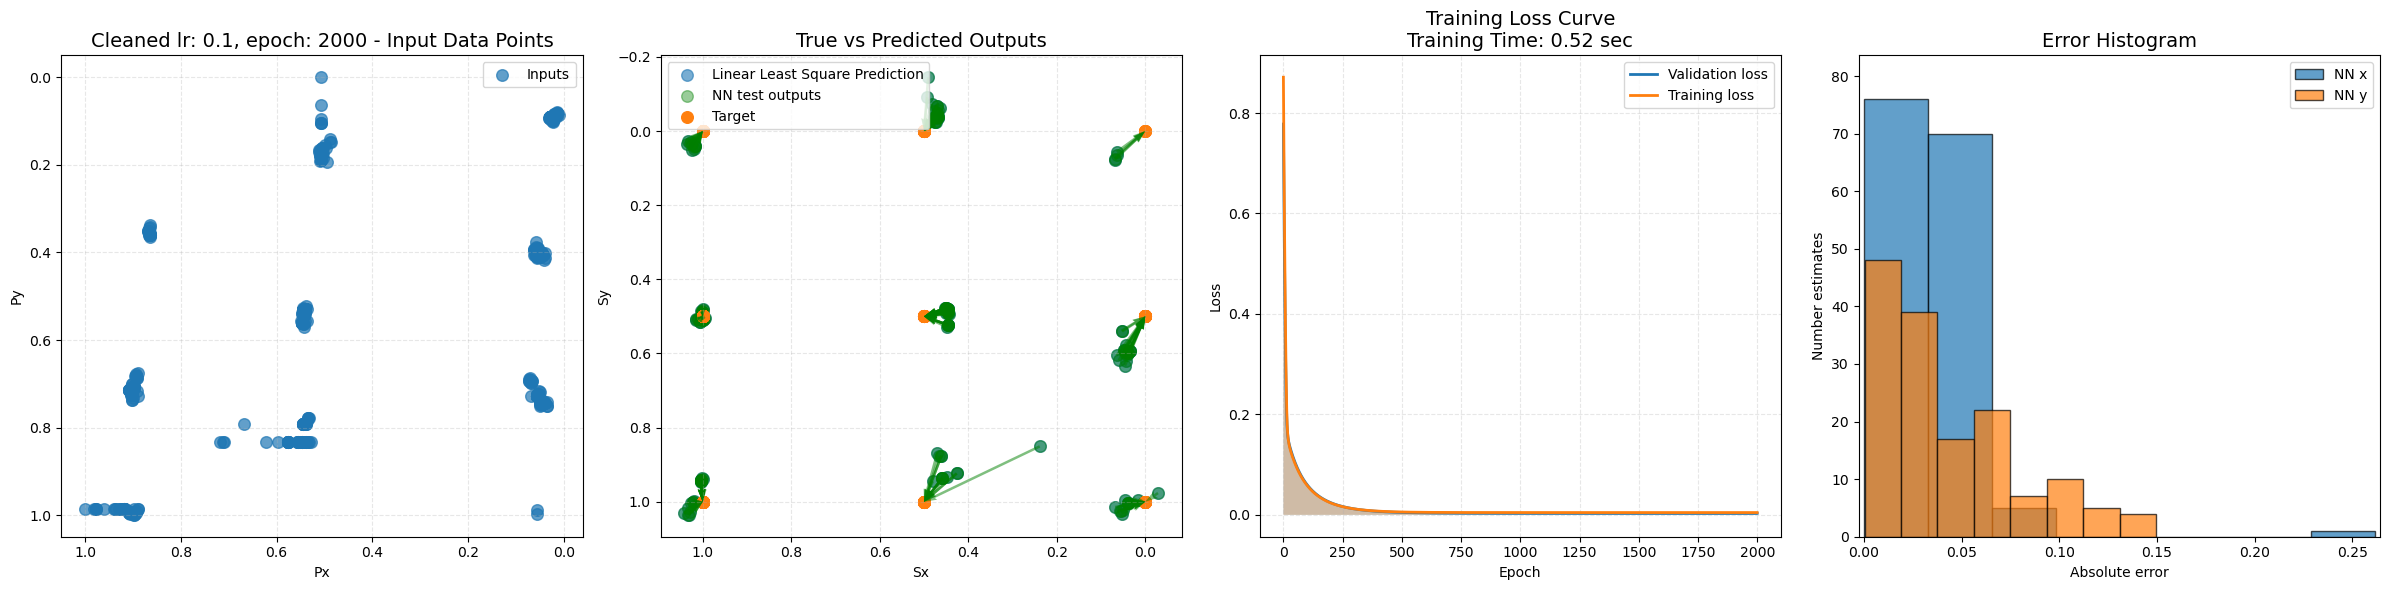

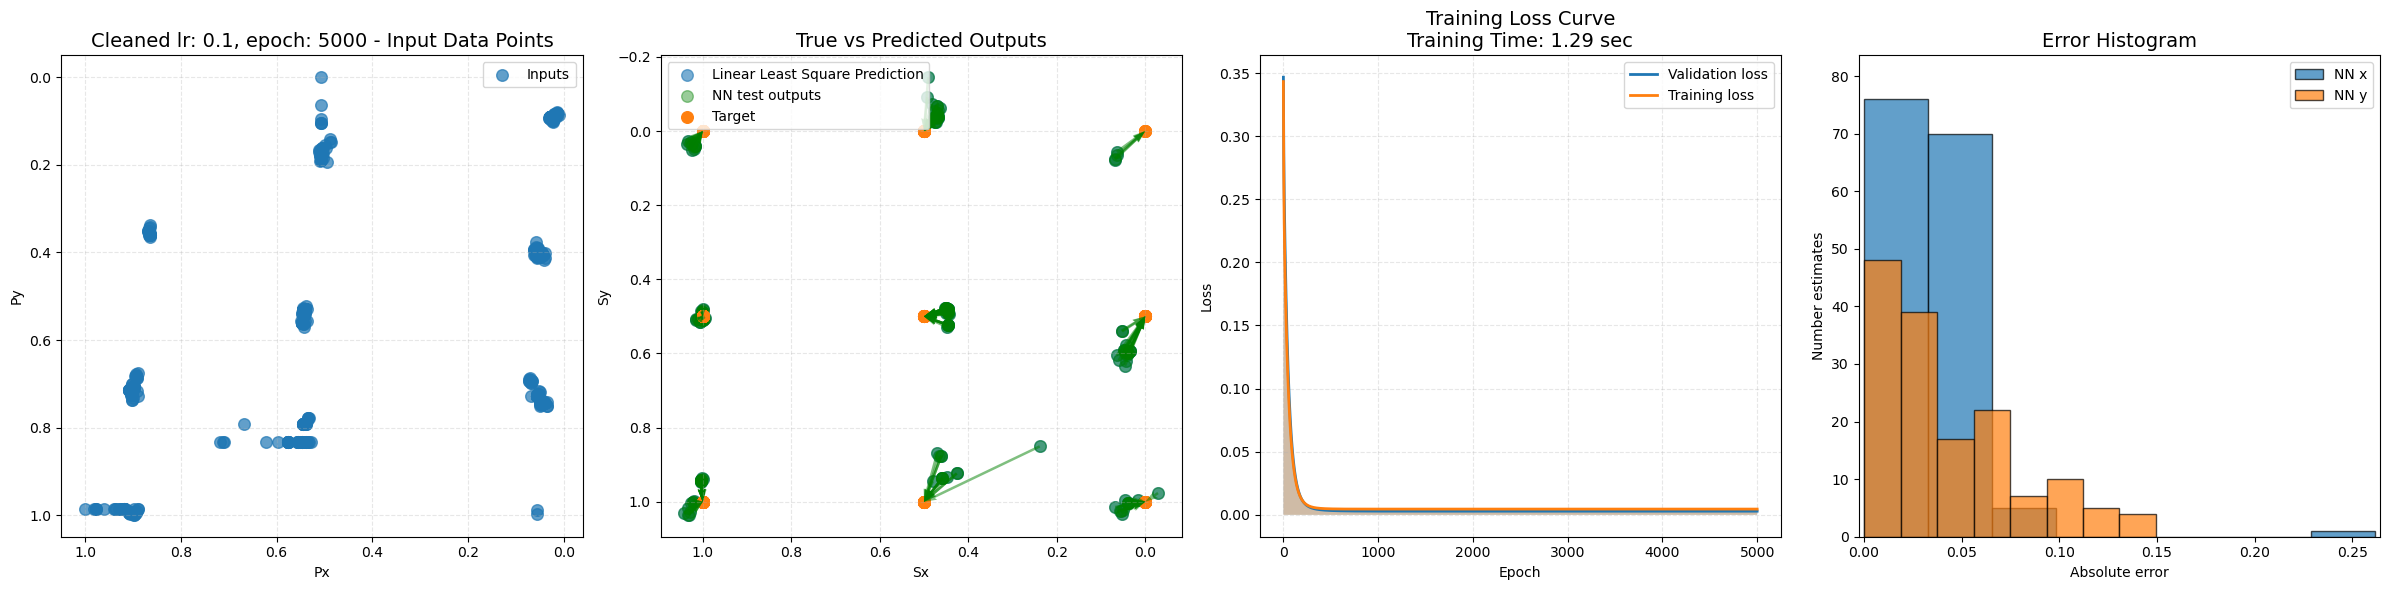

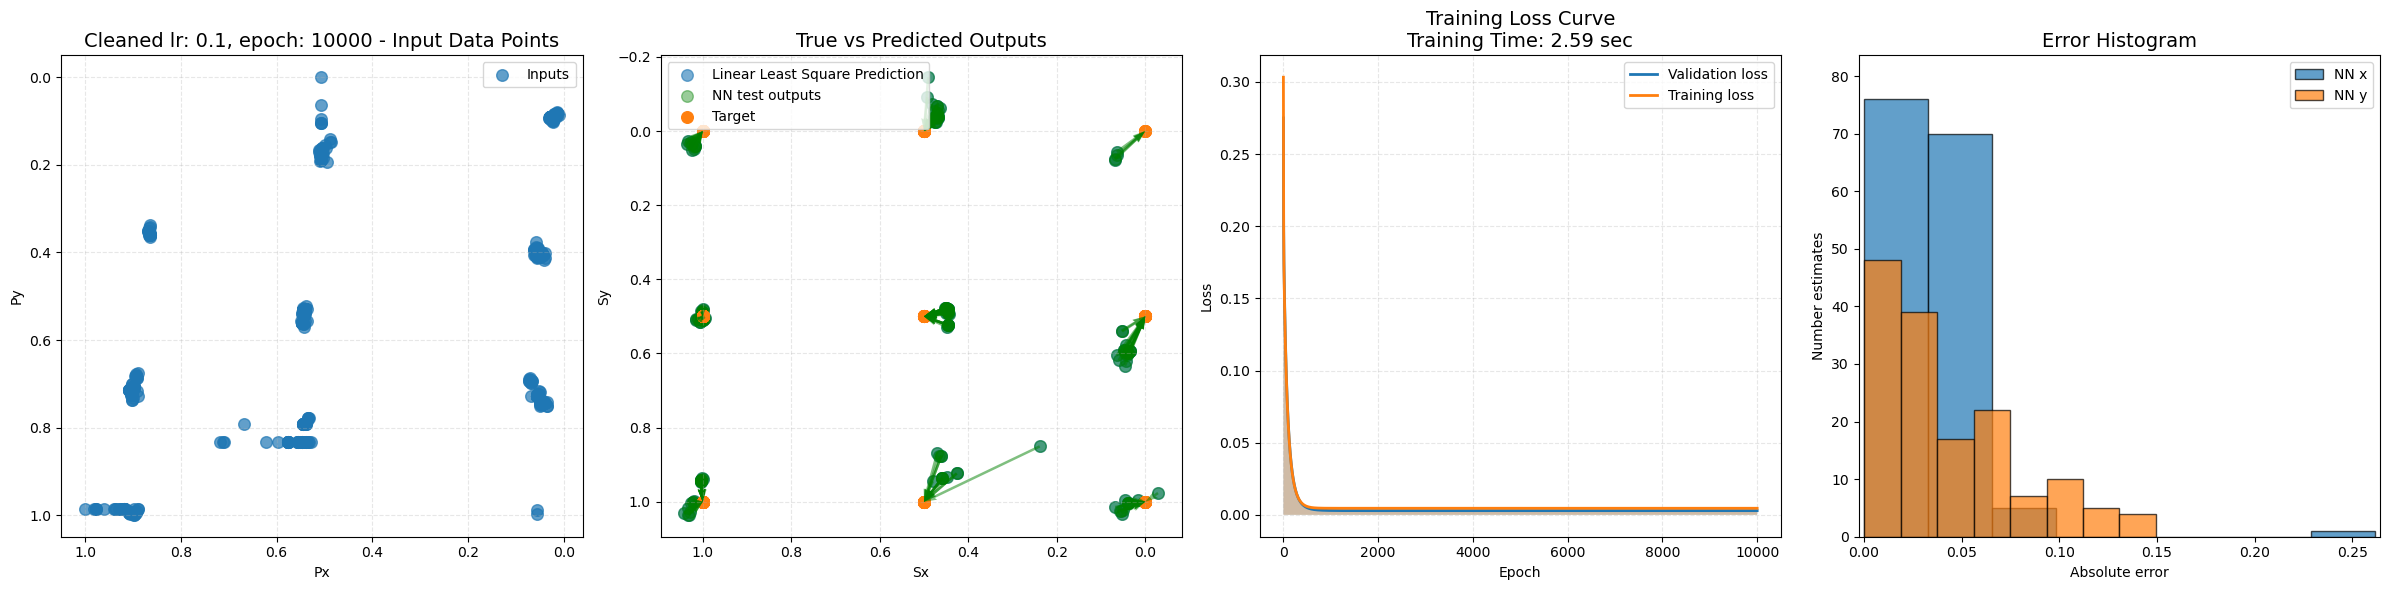

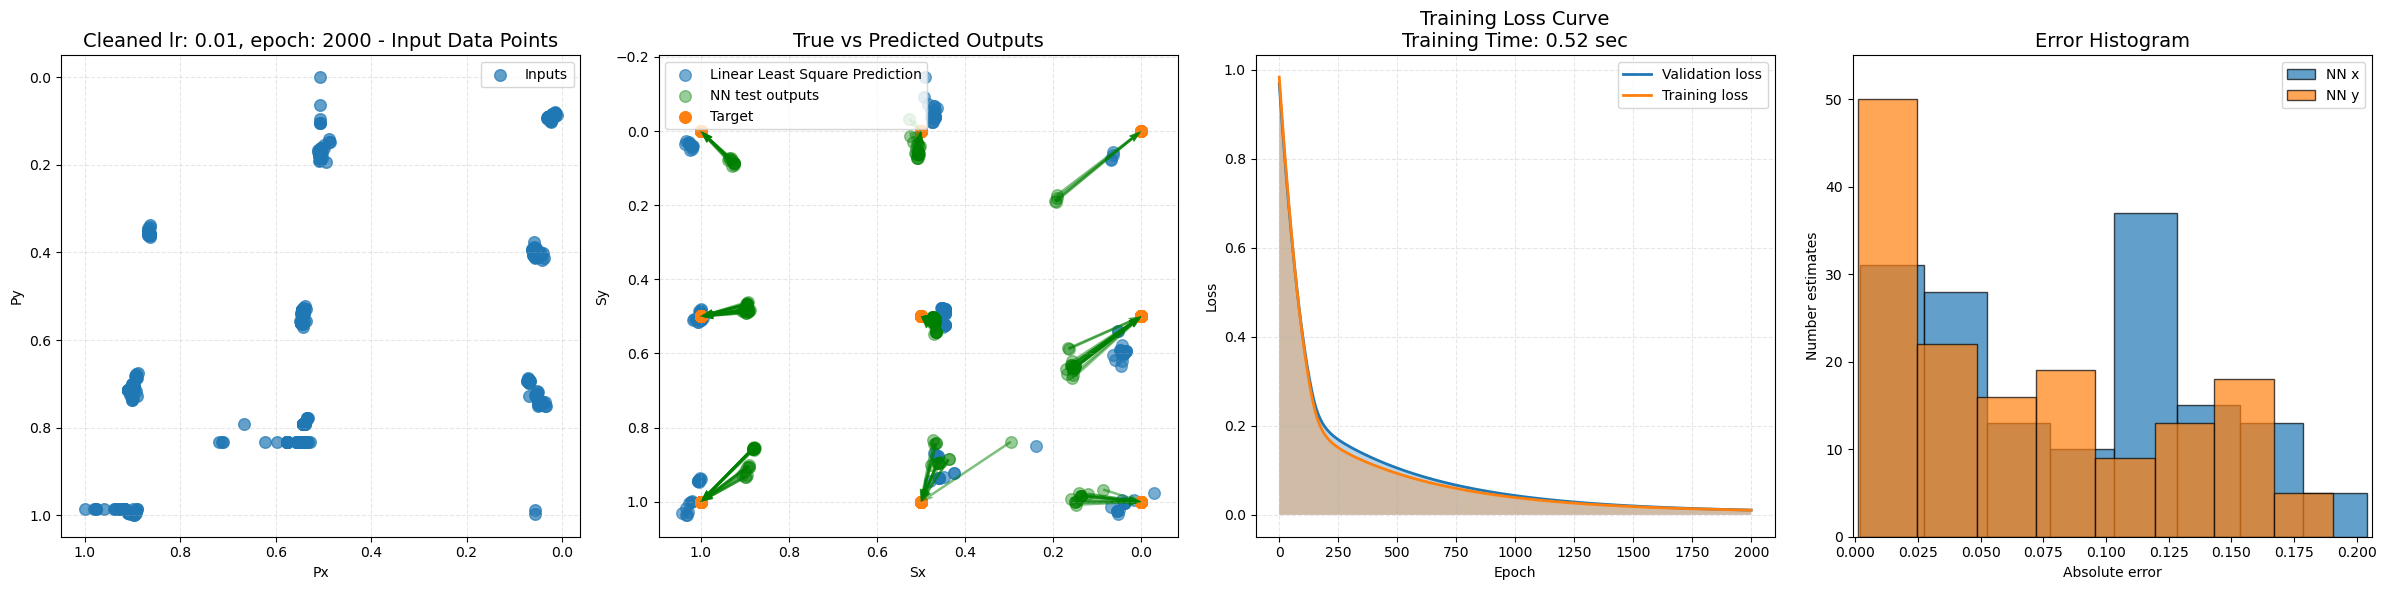

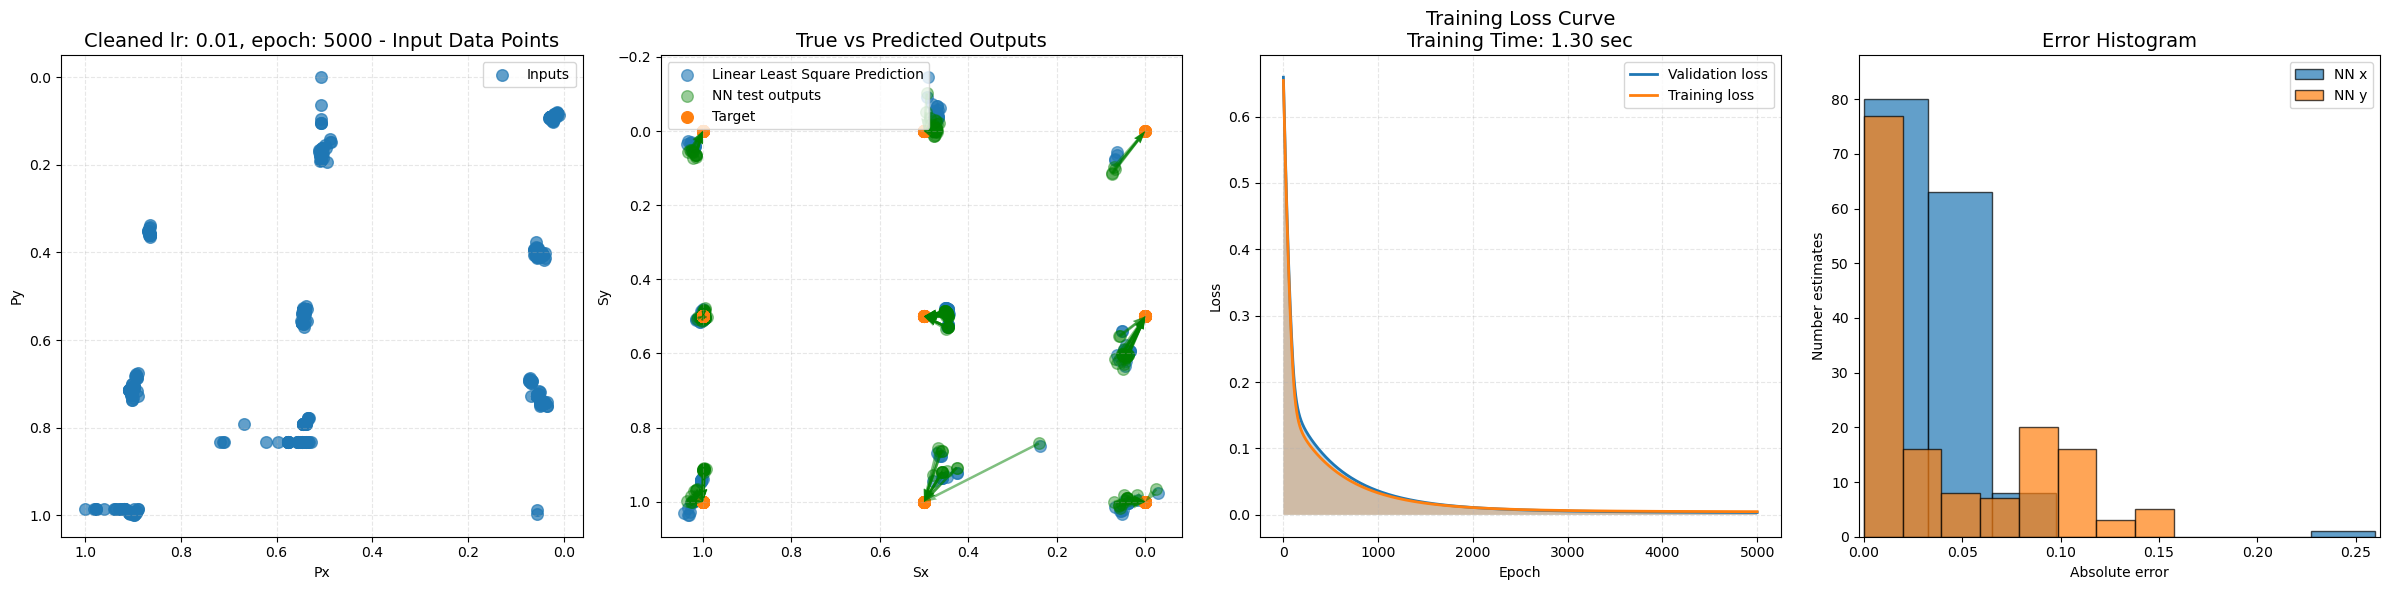

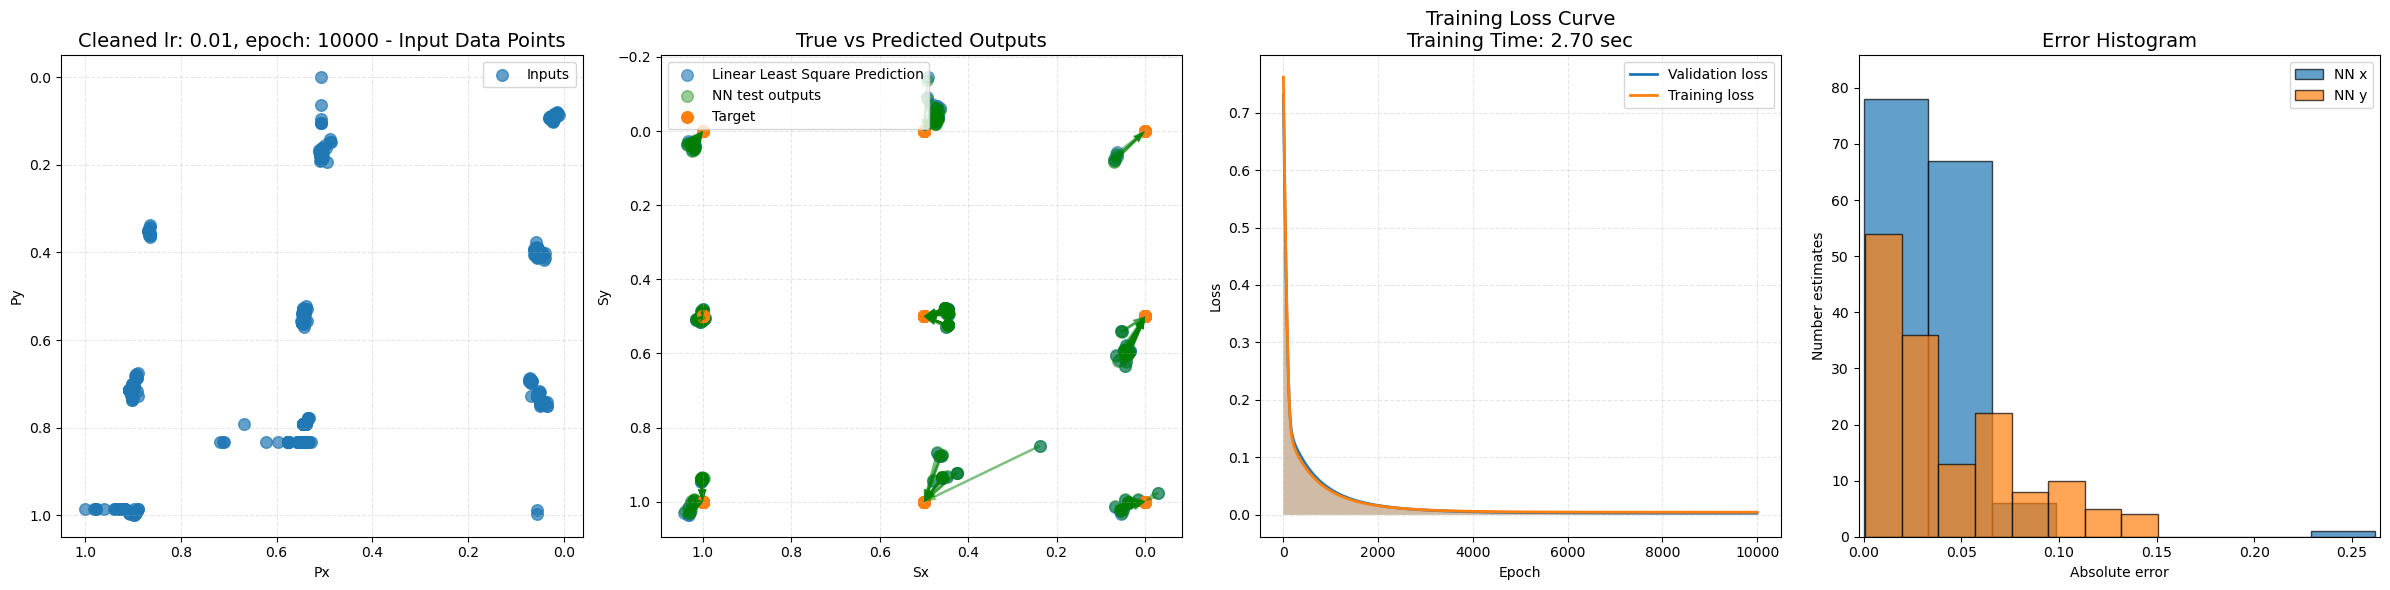

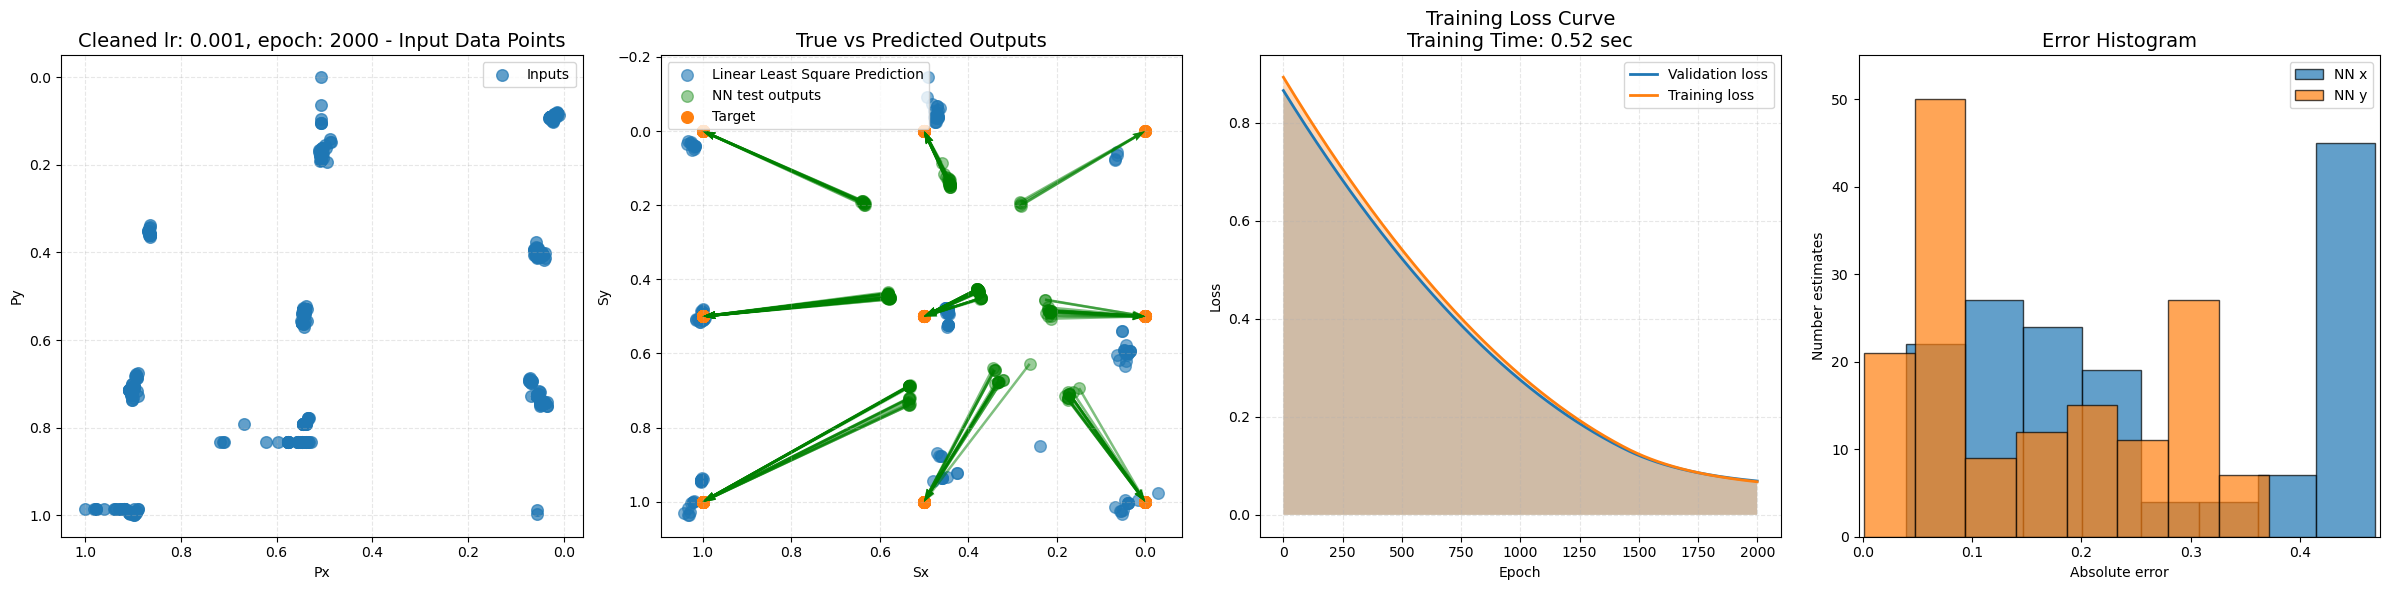

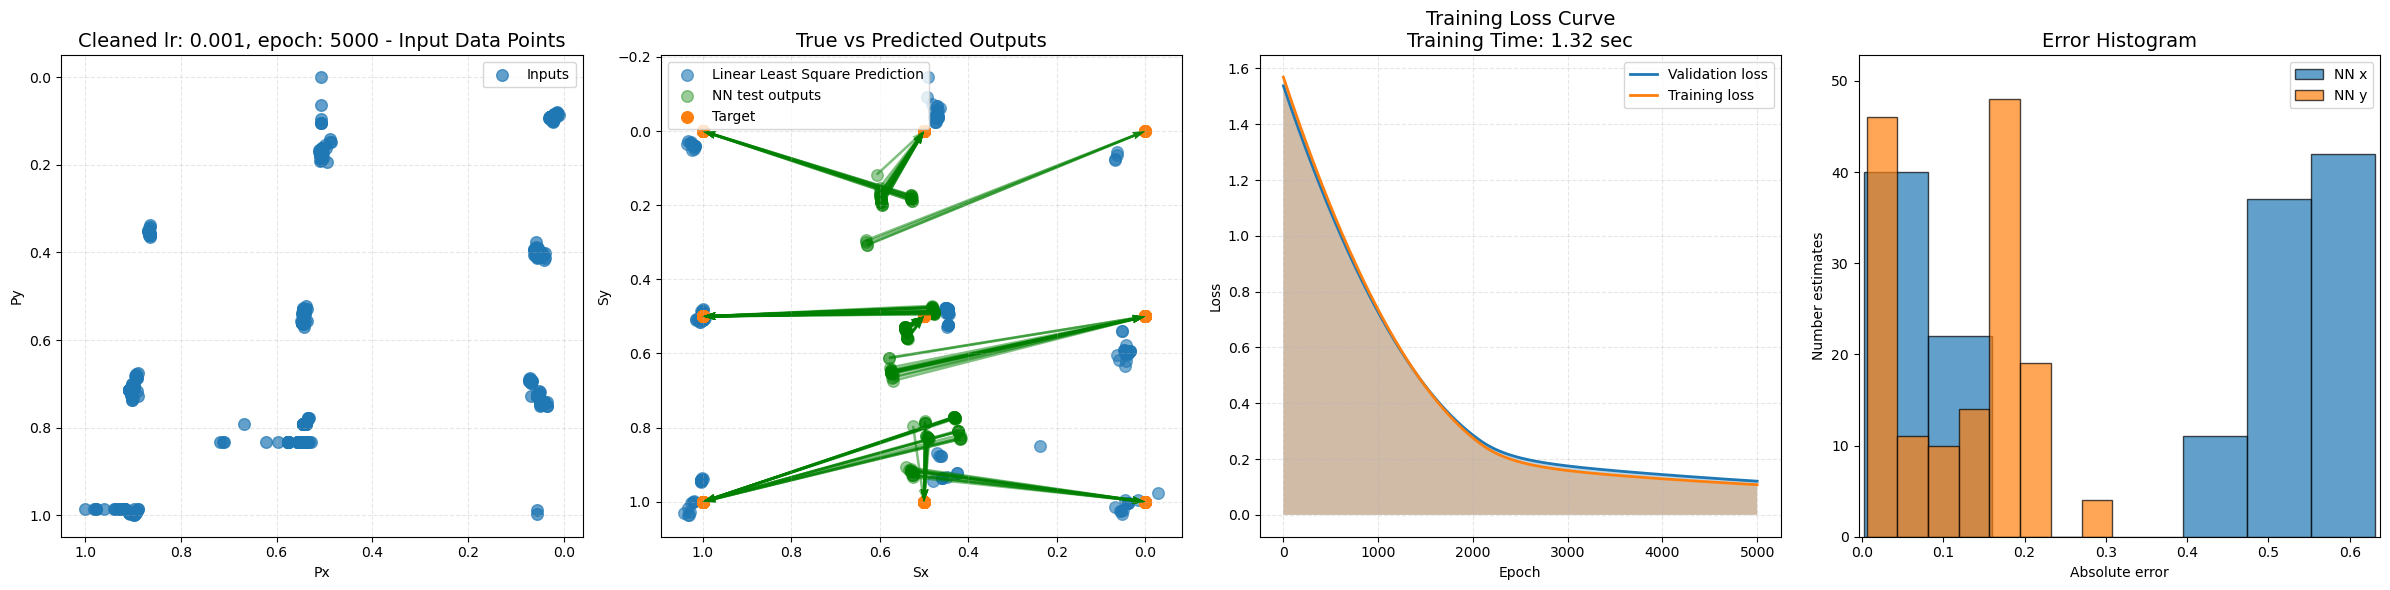

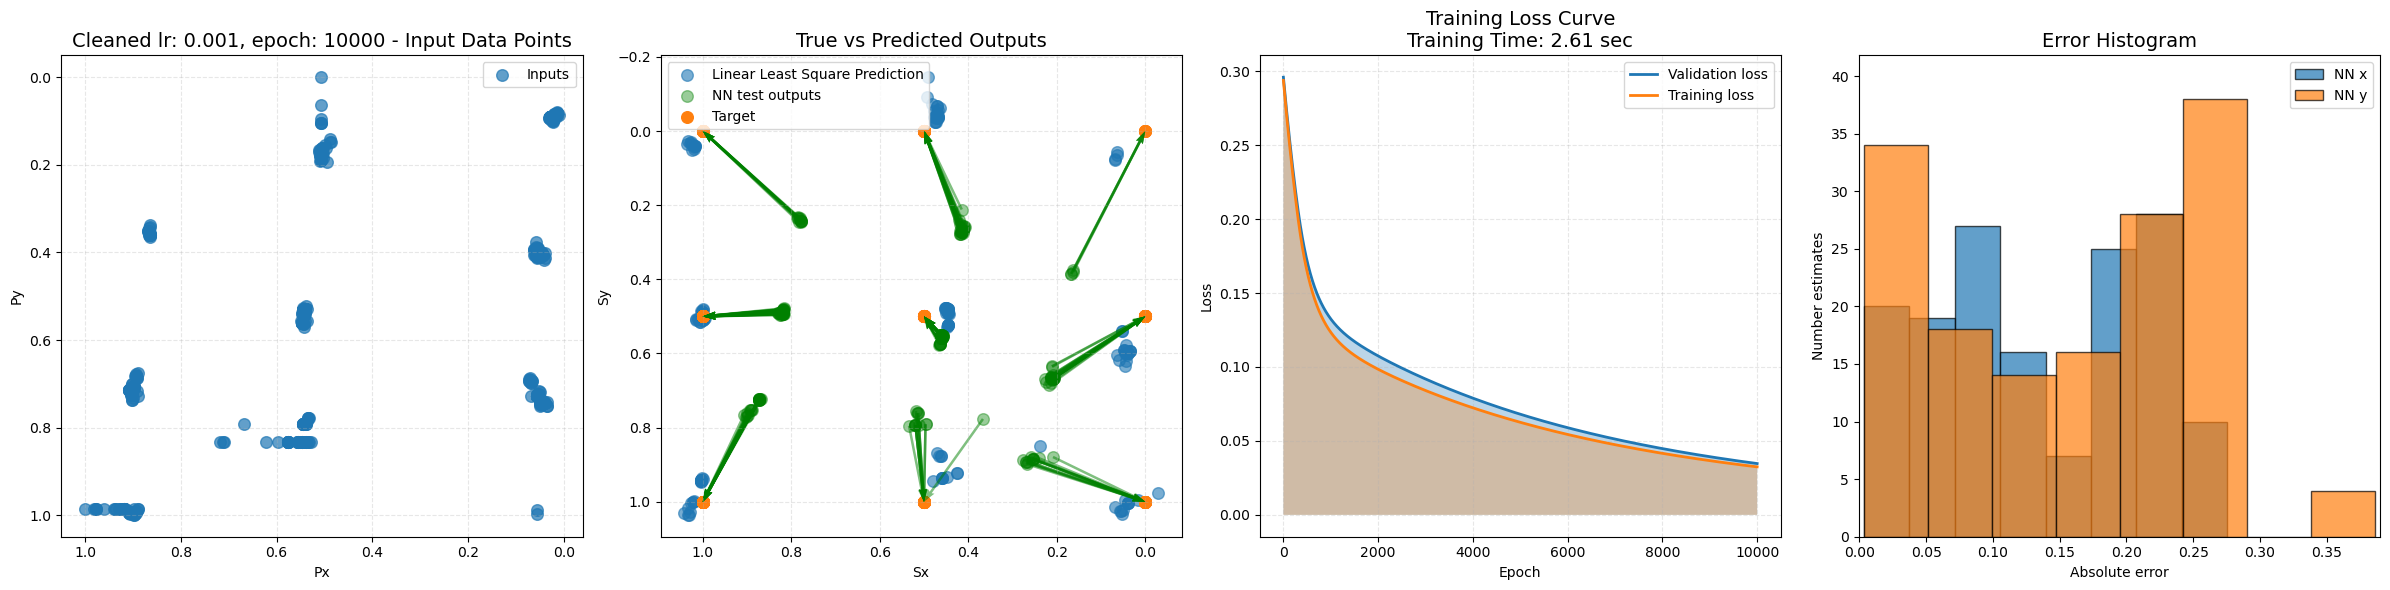

In [142]:
import numpy as np
import torch
from torch.nn import MSELoss
from torch.optim import SGD
import nn_util

# Load cleaned input and label data
cleaned_input = nn_util.load_from_csv('data/cleaned_pupils.csv')
cleaned_label = nn_util.load_from_csv('data/cleaned_screen_coordinates.csv')

# Set hyperparameters
input_dim = 2
output_dim = 2
learning_rate = [0.1, 0.01, 0.001]
epoch = [2000, 5000, 10000]
criterion = MSELoss()

# Initialize dictionaries to store results
models_dict_cleaned = {}
losses_dict_cleaned = {}
losses_val_dict_cleaned = {}
training_time_dict_cleaned = {}
pred_norm_cl = {}
errors_norm_cl = {}

models_dict_arc = {}
losses_dict_arc = {}
losses_val_dict_arc = {}
training_time_dict_arc = {}
pred_norm_arc = {}
errors_norm_arc = {}
mse_arc = {}

# Normalize the cleaned data
scaler_cleaned = DataScaler()
X_cleaned = scaler_cleaned.normalize(cleaned_input)
Y_cleaned = scaler_cleaned.normalize(cleaned_label)

# Split the cleaned data into training, validation, and test sets
X_train_cl, X_test_cl, Y_train_cl, Y_test_cl = train_test_split(X_cleaned, Y_cleaned, test_size=0.2, random_state=42)
X_train_cl, X_val_cl, Y_train_cl, Y_val_cl = train_test_split(X_train_cl, Y_train_cl, test_size=0.25, random_state=42)

# Convert to tensors
X_train_tensor_cl = torch.tensor(X_train_cl, dtype=torch.float32)
Y_train_tensor_cl = torch.tensor(Y_train_cl, dtype=torch.float32)
X_test_tensor_cl = torch.tensor(X_test_cl, dtype=torch.float32)
Y_test_tensor_cl = torch.tensor(Y_test_cl, dtype=torch.float32)
X_val_tensor_cl = torch.tensor(X_val_cl, dtype=torch.float32)
Y_val_tensor_cl = torch.tensor(Y_val_cl, dtype=torch.float32)

# Training loop for cleaned data
best_mse = float('inf')  # To track the best performing model

for lr in learning_rate:
    for epochs in epoch:
        # Initialize the model and optimizer
        model_cl = LinearModel(input_dim, output_dim)
        optimizer_cl = SGD(model_cl.parameters(), lr=lr)

        # Train the model
        losses_cl, val_losses_cl, training_time_cl = train_model(
            model_cl, criterion, optimizer_cl, X_train_tensor_cl, Y_train_tensor_cl,
            X_val_tensor_cl, Y_val_tensor_cl, num_epochs=epochs
        )

        # Test the model
        mse_cl, pred_cl, true_cl, errors_cl = test_model(model_cl, X_test_tensor_cl, Y_test_tensor_cl)

        # Store results for cleaned data
        key_cl = f"Cleaned lr: {lr}, epoch: {epochs}"
        models_dict_cleaned[key_cl] = model_cl
        losses_dict_cleaned[key_cl] = losses_cl
        losses_val_dict_cleaned[key_cl] = val_losses_cl
        training_time_dict_cleaned[key_cl] = training_time_cl
        pred_norm_cl[key_cl] = pred_cl
        errors_norm_cl[key_cl] = errors_cl

        # Update the best model
        if mse_cl < best_mse:
            best_mse = mse_cl
            models_dict_arc["best_model"] = model_cl
            losses_dict_arc["best_loss"] = losses_cl
            losses_val_dict_arc["best_val_loss"] = val_losses_cl
            training_time_dict_arc["best_time"] = training_time_cl
            pred_norm_arc["best_pred"] = pred_cl
            errors_norm_arc["best_error"] = errors_cl

# Visualize results using the collected data
nn_util.plot_results_collected(
    cleaned_input, 
    X_train_tensor_cl, Y_train_tensor_cl, 
    X_test_tensor_cl, Y_test_tensor_cl, 
    pred_norm_cl, errors_norm_cl, 
    models_dict_cleaned, 
    losses_dict_cleaned, 
    losses_val_dict_cleaned, 
    training_time_dict_cleaned
)



---
**Task 14 (easy): Reflections on model performance💡**
1. Given that 39/796 coordinates in the `cleaned`
 dataset were removed as outliers, reflect on the how the type of outliers influence model performance by comparing the model trained on the uncleaned normalized dataset in task [Task 10](#prediction100) to the model in task [Task 13](#cleaned). Include the following points in your discussion:    - Why do only 39 points significantly affect the model’s performance?
    - How does the division of training and test data influence the model’s performance?
    - What methods could be used to perform an in-depth analysis of such data splits?




---

## Task 14 reflections


## 1. Impact of Outliers on Model Performance
- **Why do only 39 points significantly affect the model’s performance?**
  - Outliers often represent extreme deviations from the general trend of the data. These points can disproportionately influence the model by:
    - Skewing the loss function, leading the model to prioritize minimizing error on these outliers instead of fitting the majority of the data.
    - Introducing noise that reduces the ability of the model to learn underlying patterns effectively.
  - Even though 39 points represent a small fraction of the total dataset (39/796 ≈ 4.9%), their extreme values amplify their effect, especially in regression tasks where error scales quadratically with deviation.

---

## 2. Influence of Data Division on Model Performance
- **How does the division of training and test data influence the model’s performance?**
  - The training-test split plays a critical role in determining model performance:
    - If outliers are unevenly distributed between training and test sets, the model's performance can vary significantly:
      - Training on outlier-dominated data can lead to overfitting, causing poor generalization on clean test data.
      - Testing on outlier-dominated data can result in higher evaluation errors, even if the model performs well on clean training data.
    - Ensuring a balanced split (e.g., stratified sampling or outlier removal before splitting) can mitigate such discrepancies.

---

## 3. Methods for In-Depth Analysis of Data Splits
- **What methods could be used to perform an in-depth analysis of such data splits?**
  - **Visualization**:
    - Scatter plots of training and test data to observe the distribution of outliers.
    - Boxplots or histograms to analyze the range and variance of coordinates across splits.
  - **Statistical Analysis**:
    - Calculate and compare key statistics (mean, variance, skewness) for training and test sets.
    - Use metrics like Mahalanobis distance or z-scores to detect and quantify outliers.
  - **Cross-Validation**:
    - Use k-fold or stratified cross-validation to ensure robustness across multiple data splits.
    - Evaluate model performance consistency by rotating test sets and identifying anomalies in results.
  - **Error Analysis**:
    - Examine residual errors for training and test data separately.
    - Identify patterns where the model consistently underperforms, suggesting the impact of specific data points.

---

By comparing the cleaned and uncleaned datasets, it is evident that outliers can disproportionately affect the model's ability to generalize. Careful data preparation, balanced splits, and robust evaluation strategies are crucial for reliable model performance.


## Non-linear Model
The following steps are about two different architectures for non-linear models. Compare the non-linear models to the affine model as done above. 

---
**Task 15 (easy): Analyse architecture💡**
1. Examine the cell below to get an overview of the two neural architectures and identify the main differences between the models.


---

In [0]:
class LinearModelRelu(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearModelRelu, self).__init__()
        self.linear1 = nn.Linear(input_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        return x

class LinearModelRelu_exp(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LinearModelRelu_exp, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.linear3(x)
        return x

## Task 15 reflection - Analysis of Non-Linear Architectures

## Overview of Architectures
### 1. **LinearModelRelu**
- **Architecture**:
  - A single fully connected (`Linear`) layer.
  - A ReLU (Rectified Linear Unit) activation applied to the output of the linear layer.
- **Key Characteristics**:
  - Simple architecture with only one transformation and one activation function.
  - Capable of introducing non-linear transformations but limited in expressive power due to the absence of hidden layers.

---

### 2. **LinearModelRelu_exp**
- **Architecture**:
  - A deeper network consisting of:
    - Three fully connected (`Linear`) layers.
    - Two ReLU activation layers after the first two linear transformations.
  - A hidden dimension (`hidden_dim`) that allows the network to learn intermediate representations.
- **Key Characteristics**:
  - More complex than `LinearModelRelu`, with multiple layers and non-linearities.
  - The presence of hidden layers allows for hierarchical feature extraction, enabling the network to learn more intricate patterns.

---

## Main Differences Between Models
1. **Depth**:
   - `LinearModelRelu`: Single layer.
   - `LinearModelRelu_exp`: Three layers with two hidden layers.

2. **Expressive Power**:
   - `LinearModelRelu`: Limited to learning simple non-linear mappings.
   - `LinearModelRelu_exp`: Better equipped to model complex relationships due to increased depth and intermediate non-linearities.

3. **Number of Parameters**:
   - `LinearModelRelu`: Fewer parameters (only one layer's weights and biases).
   - `LinearModelRelu_exp`: More parameters due to additional layers and hidden dimensions.

4. **Suitability**:
   - `LinearModelRelu`: Suitable for simple datasets where the relationship between input and output is not highly complex.
   - `LinearModelRelu_exp`: Better suited for complex datasets with intricate, hierarchical patterns.

---

### Key Insight
The `LinearModelRelu_exp` model is a more powerful architecture capable of capturing complex patterns in data due to its depth and non-linearities. However, it also requires more data and computational resources for effective training, and it is more prone to overfitting if not regularized appropriately.



---
**Task 16 (easy): Train non-linear models (cleaned gaze data)👩‍💻**
**Note:** For the exam it may be convenient to copy the code from above to the cell below as you complete the steps. 

1. Rerun task [Task 10](#prediction100) using the normalized, cleaned data, on the two new models. The steps were:

- Train the models:
    - Create two nested for-loops looping the lists containing values for `learning rate`
 and `epochs`
. The loops should:        - Train models of both architectures on the cleaned normalized data, using the `train_model`
 function.
        - Test the models using the `test_model`
 function.
        - Save the following information in the designated dictionaries with the suffix `arc`
, for each model:            - Model 
            - Loss (training)
            - Loss (validation)
            - Training time 
            - Predictions
            - Errors 






- Use the function `plot_results_collected`
 from the `nn_util.py`
 file, to visualize the result.

- Use the function `plot_mse_bar`
 from the `nn_util.py`
 file, to visualize the mean squared error compared.



---

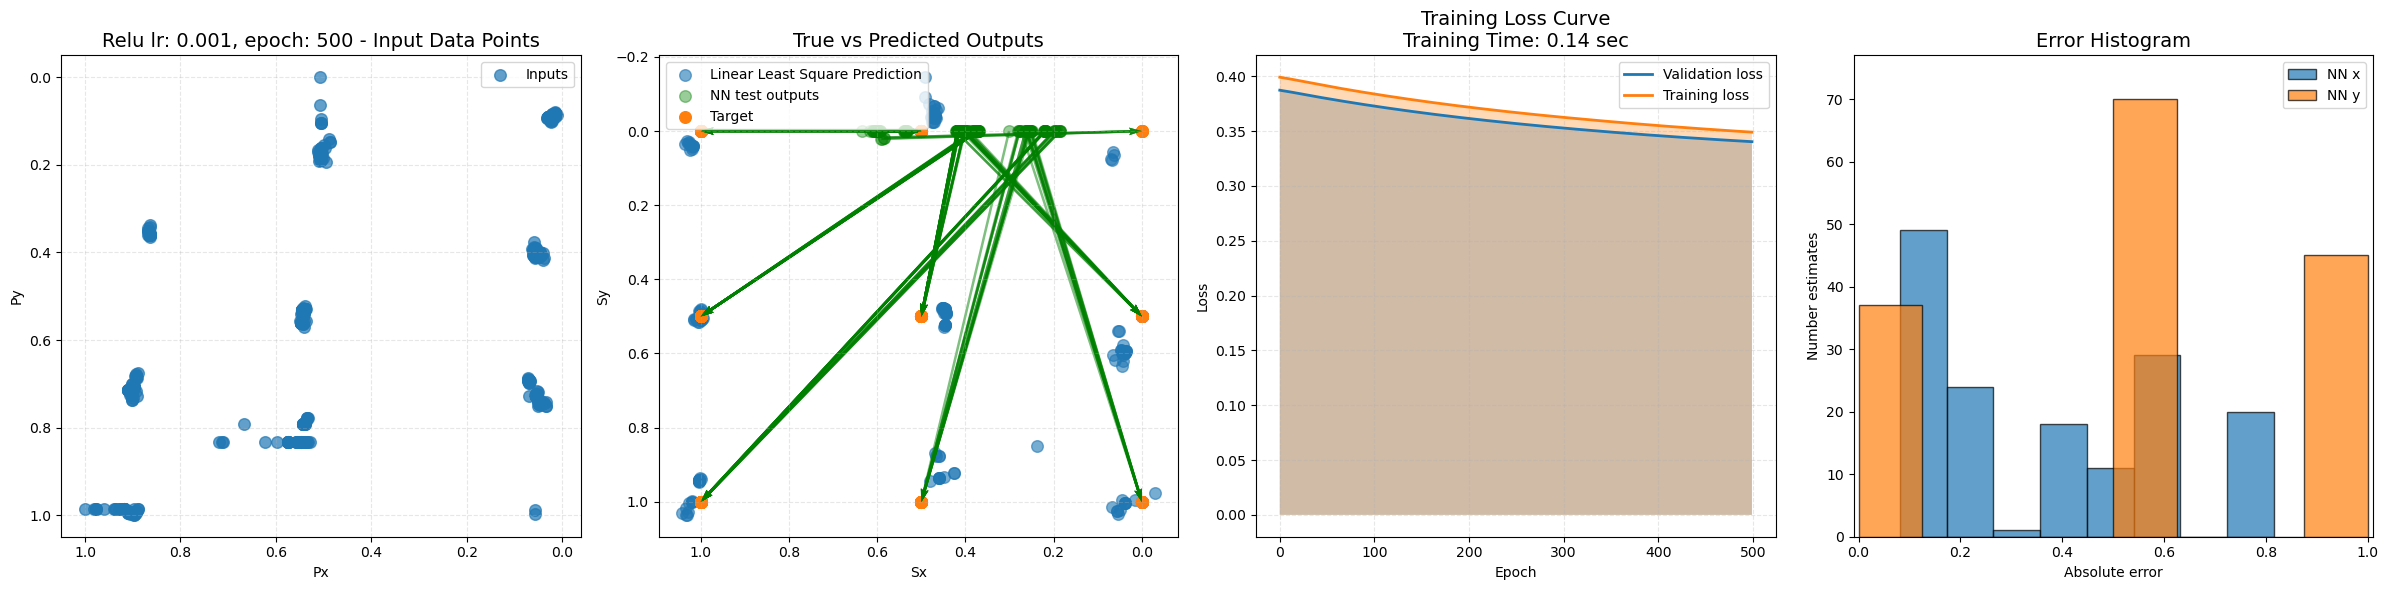

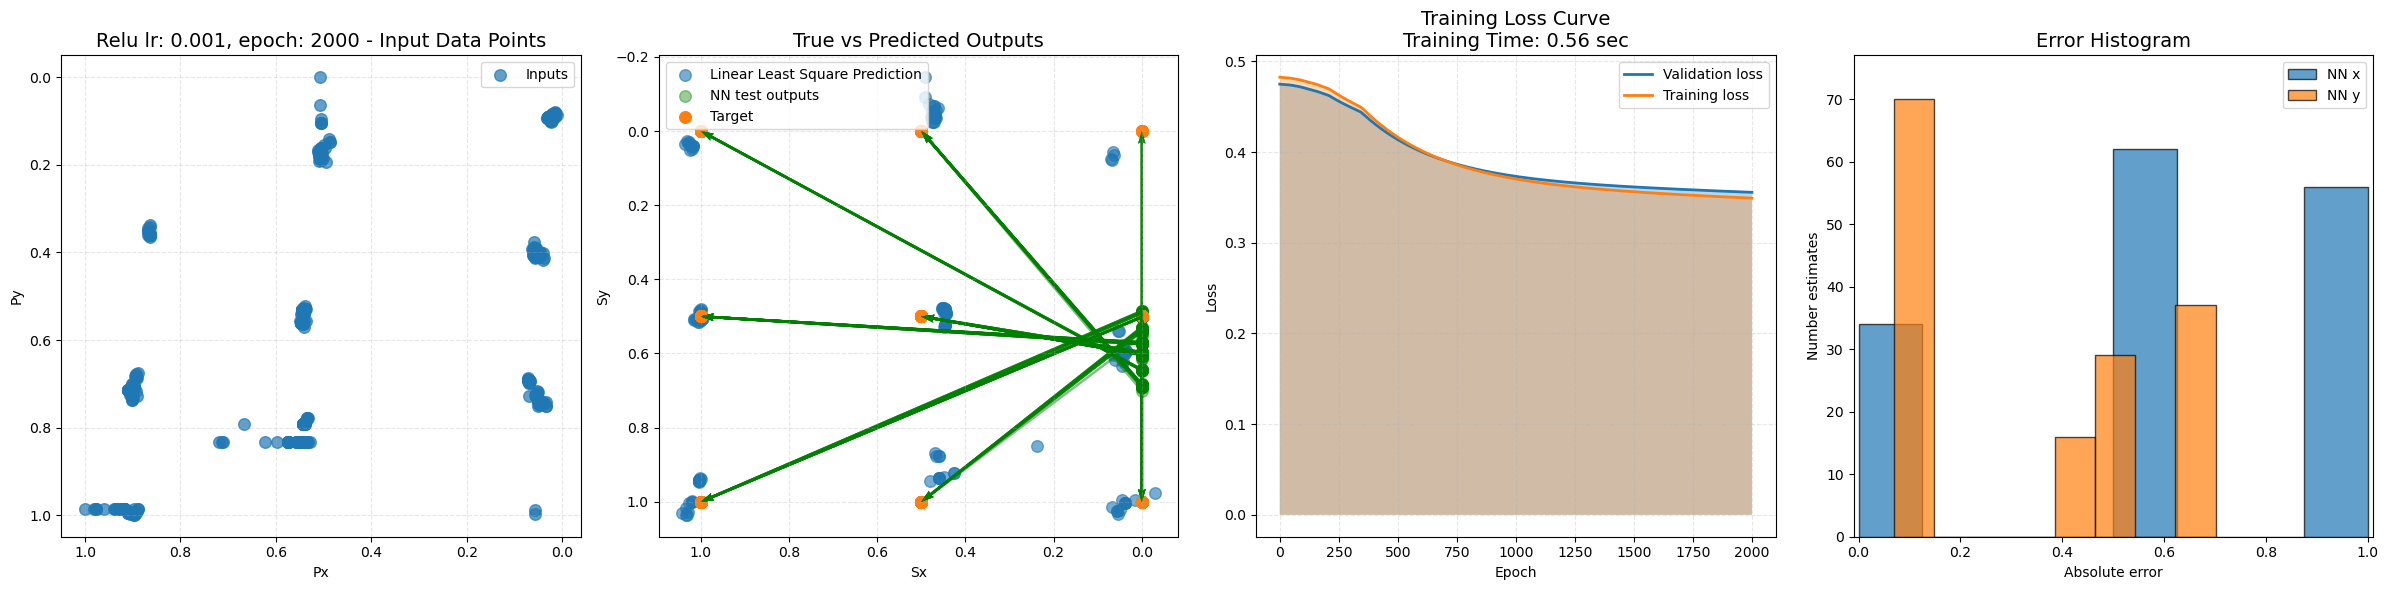

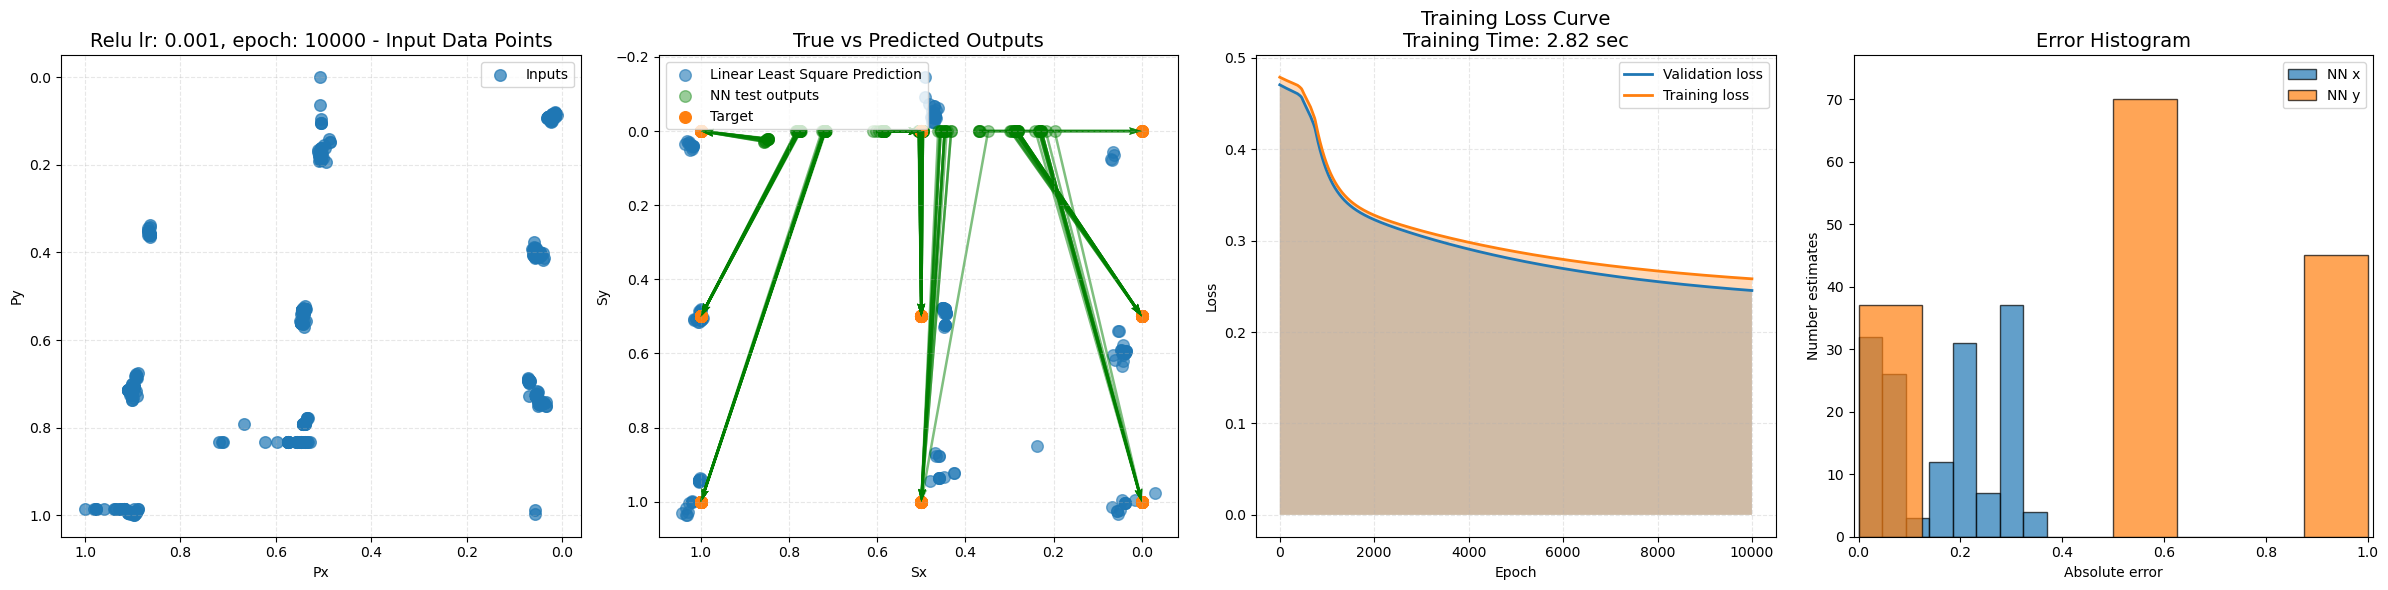

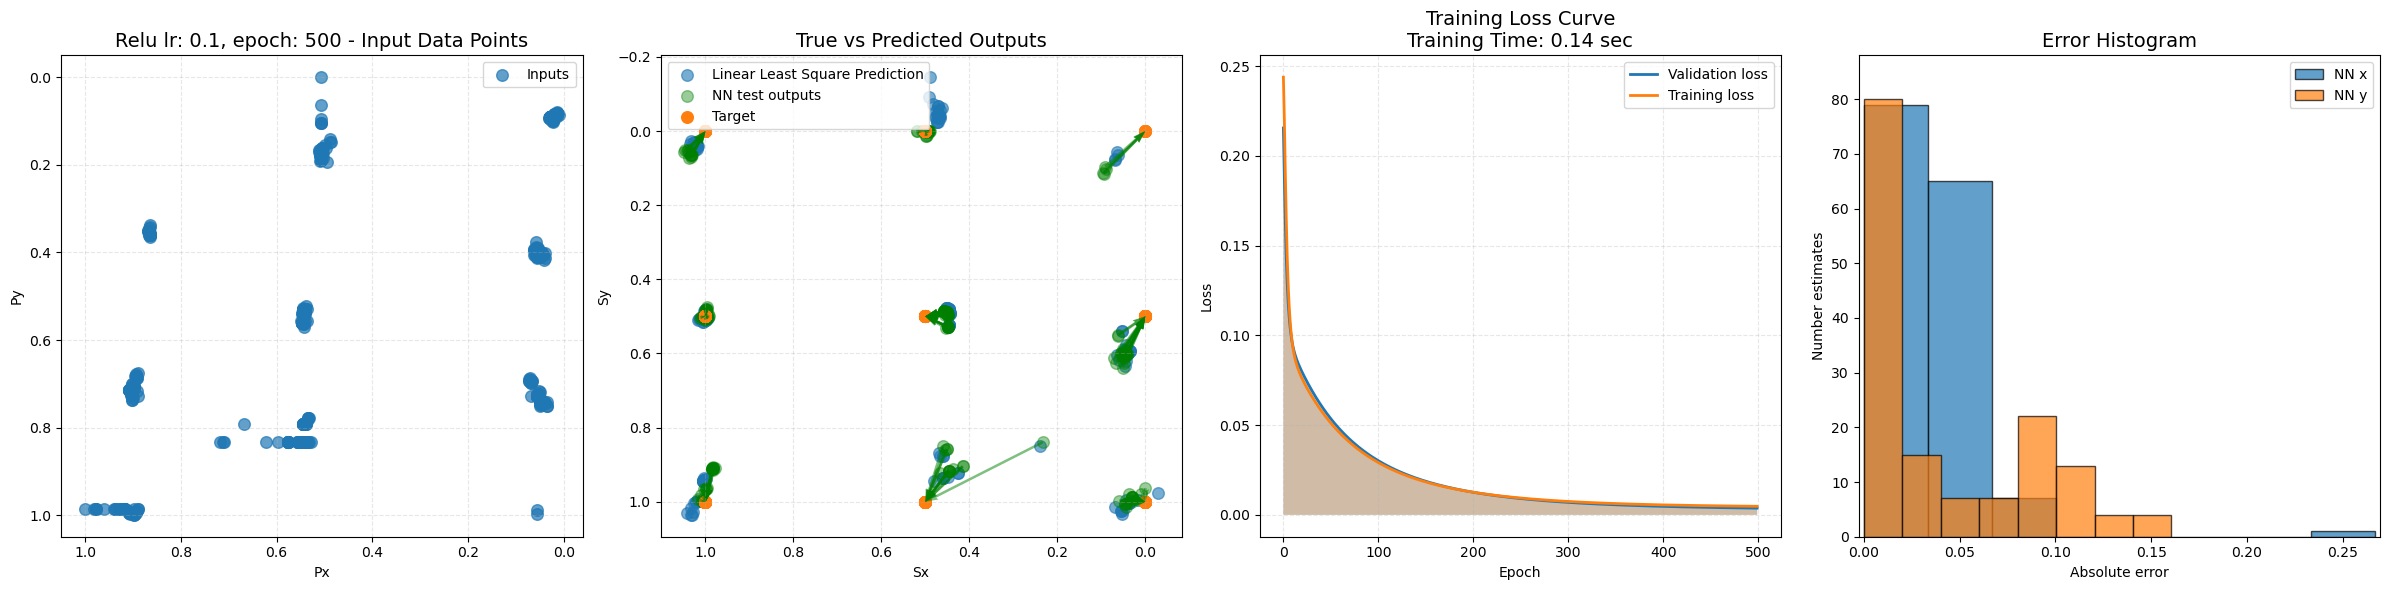

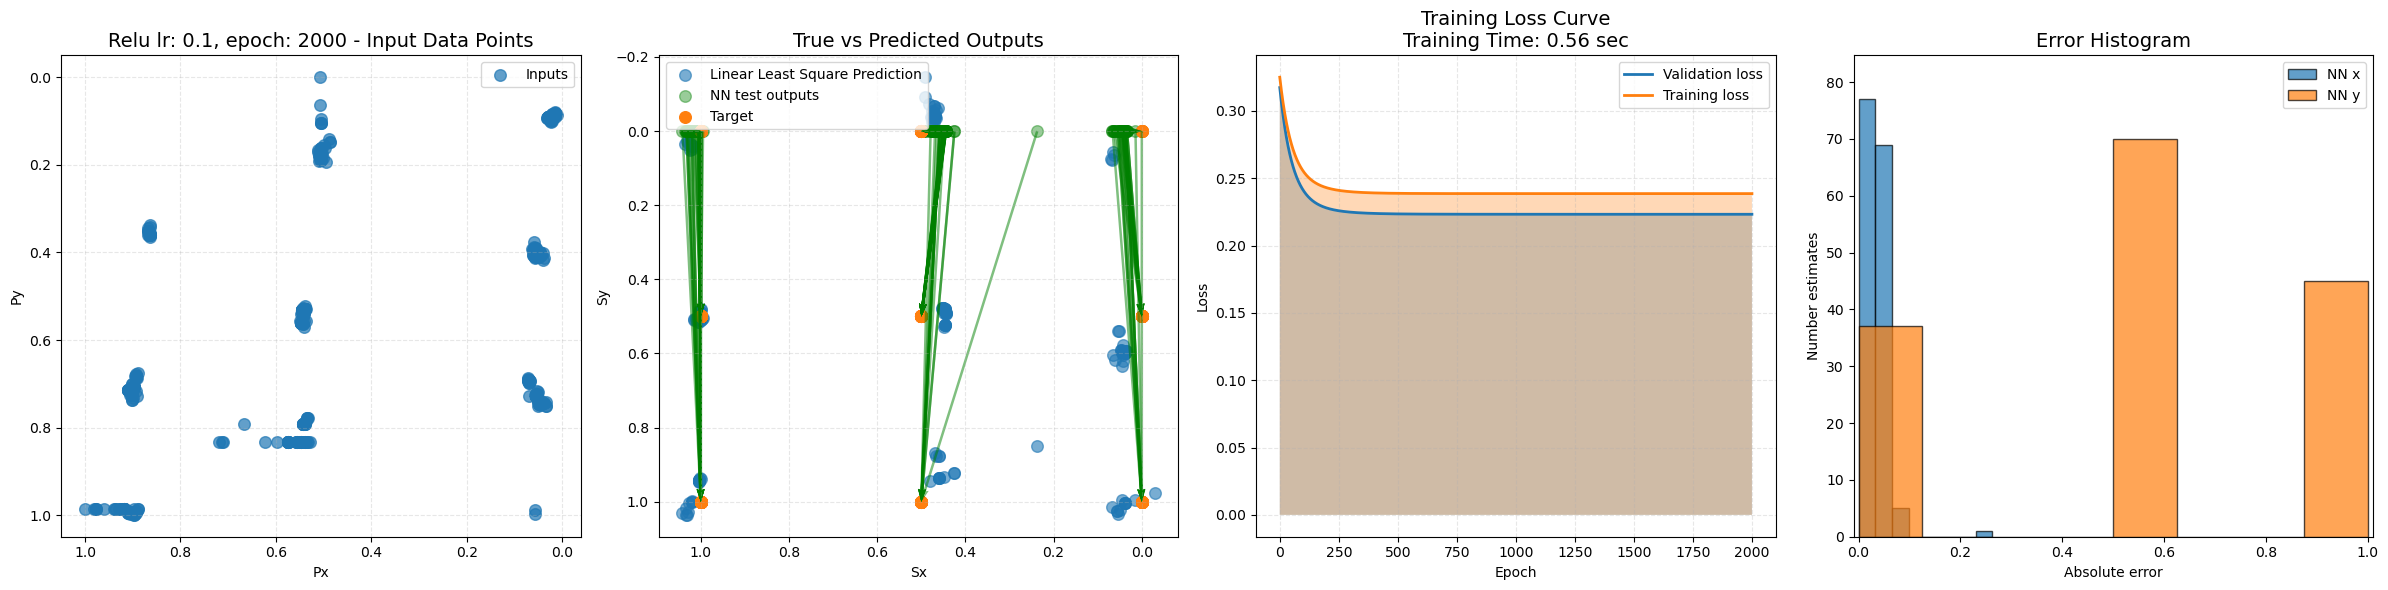

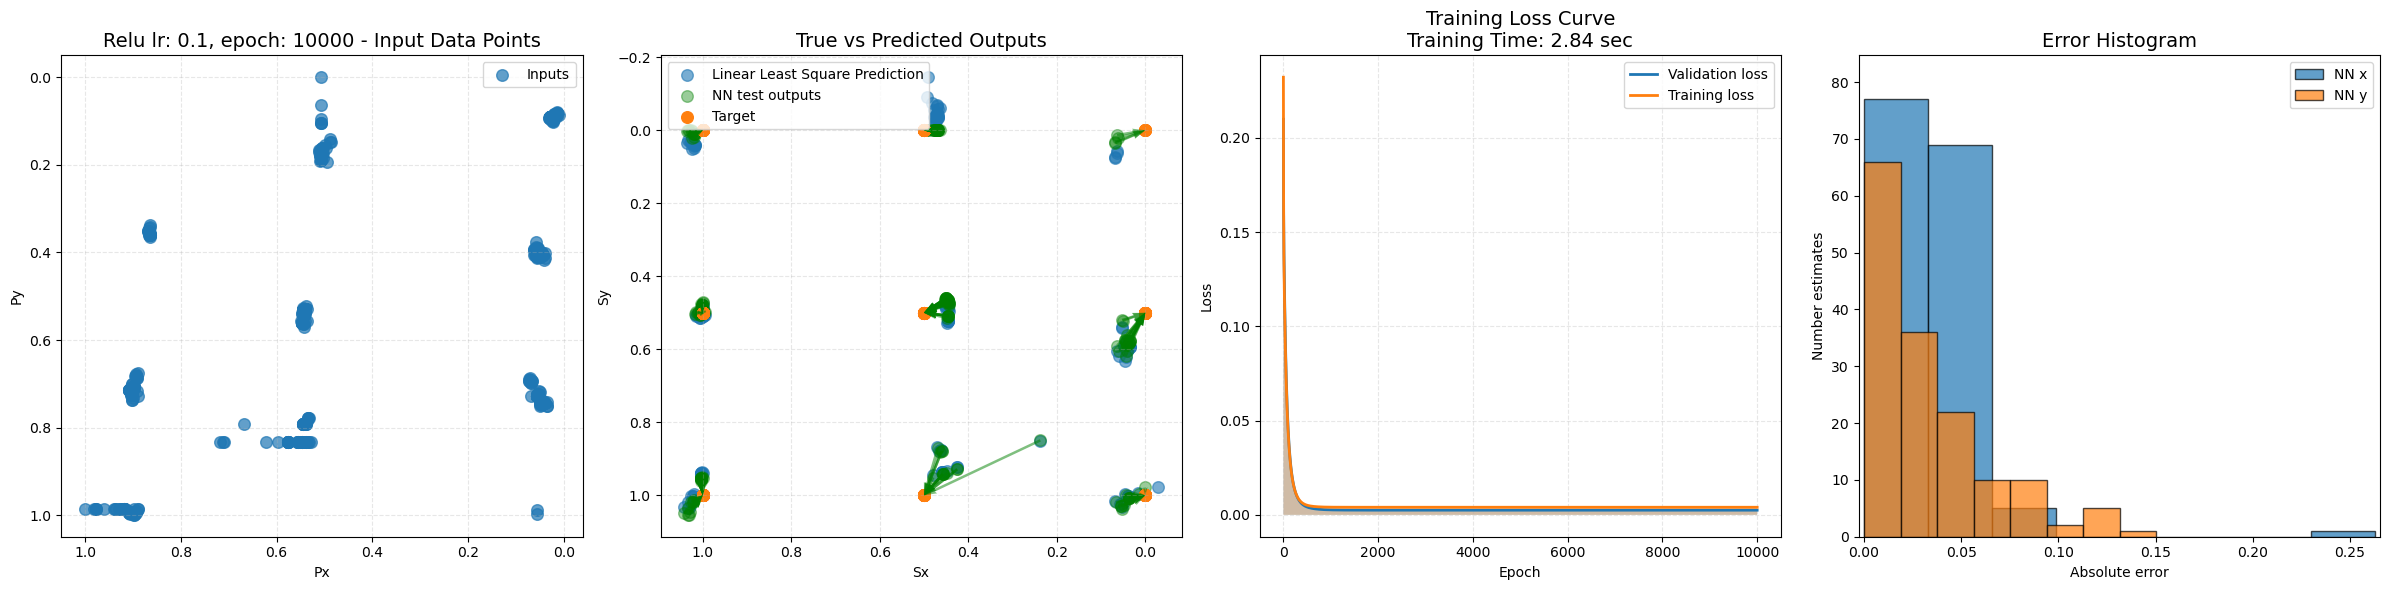

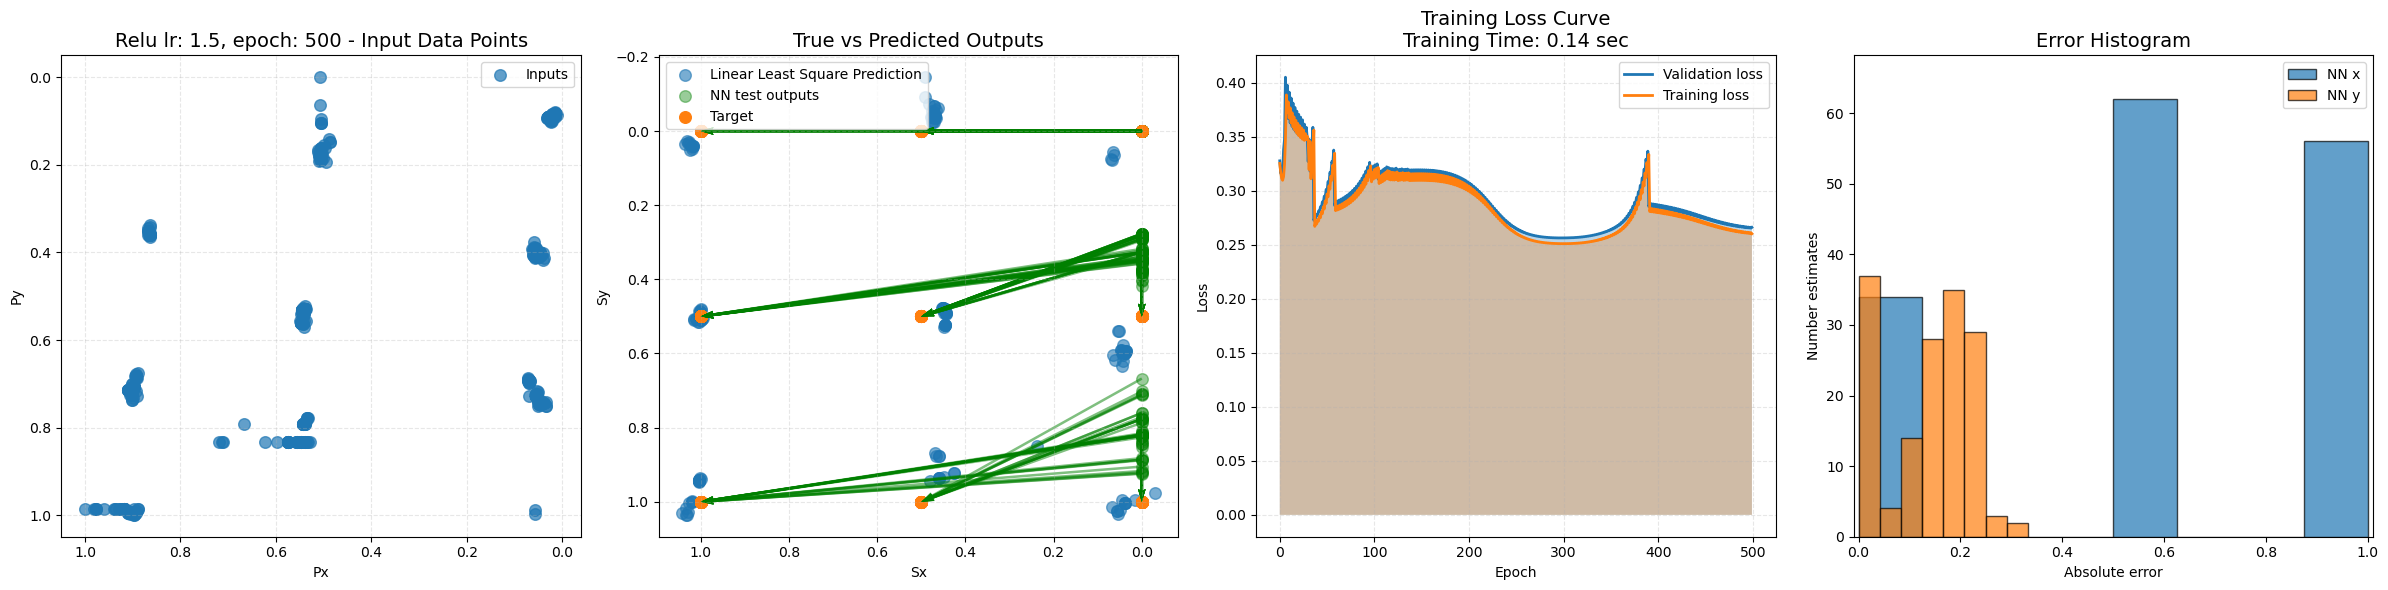

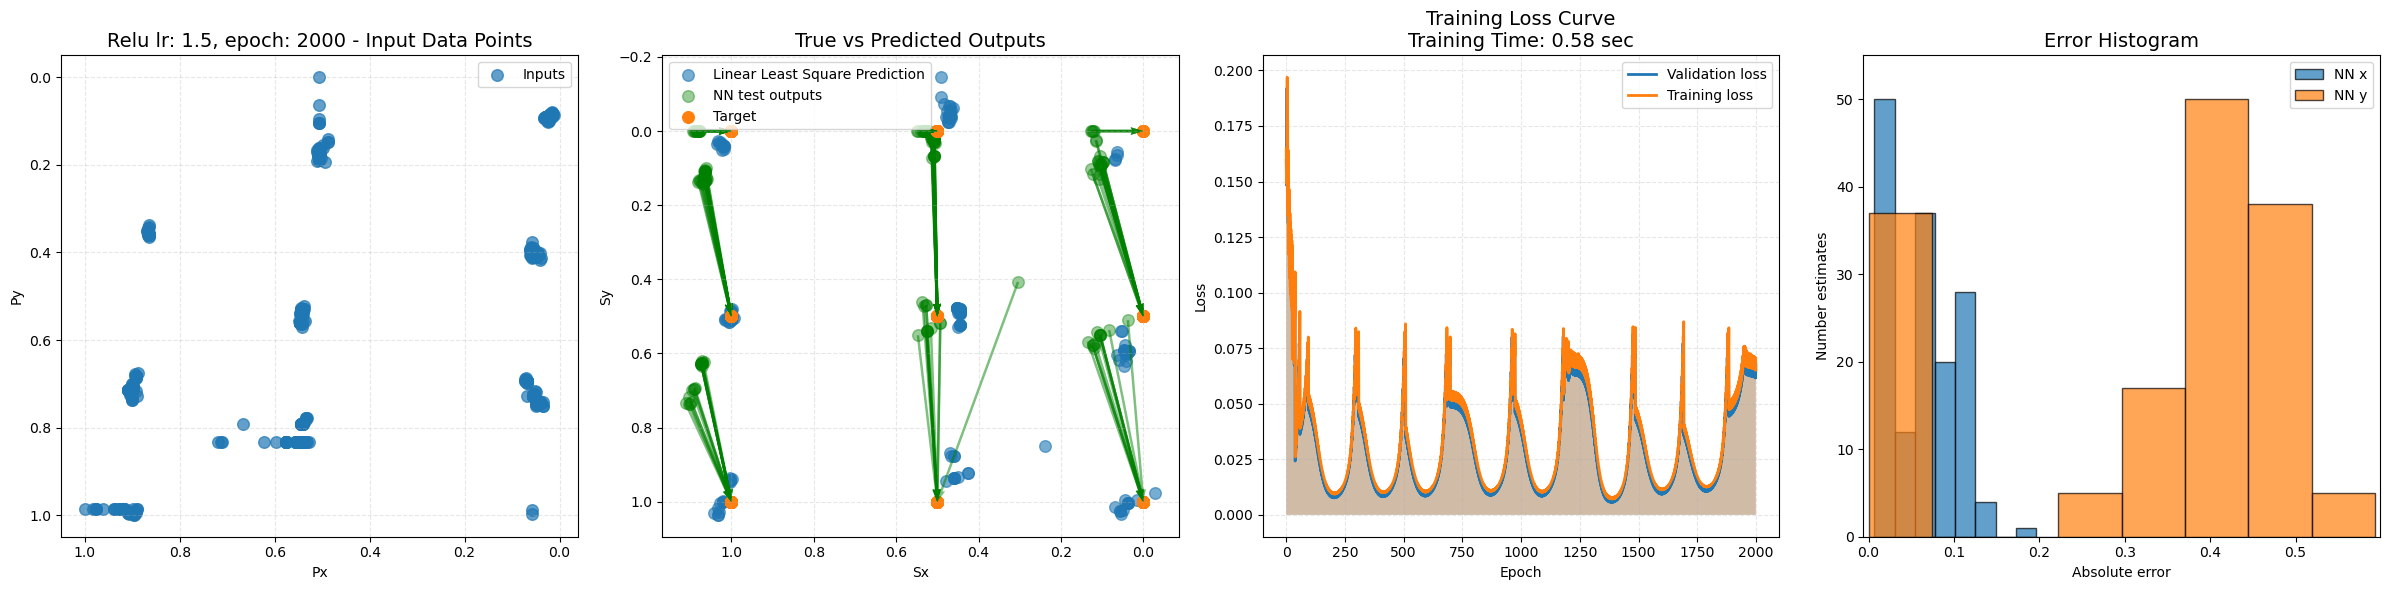

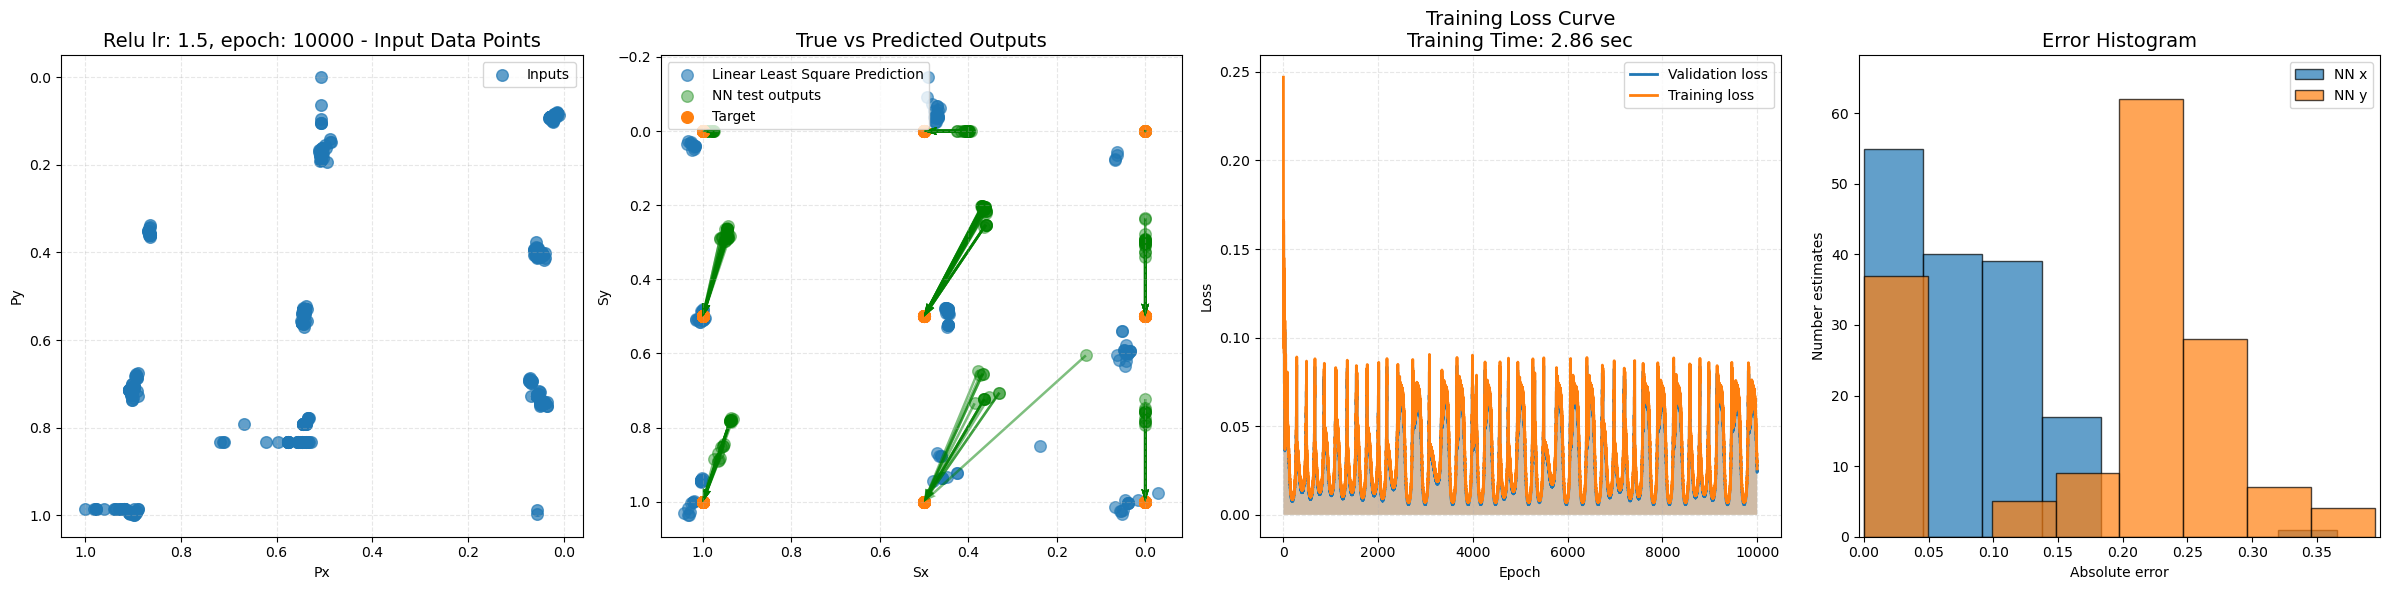

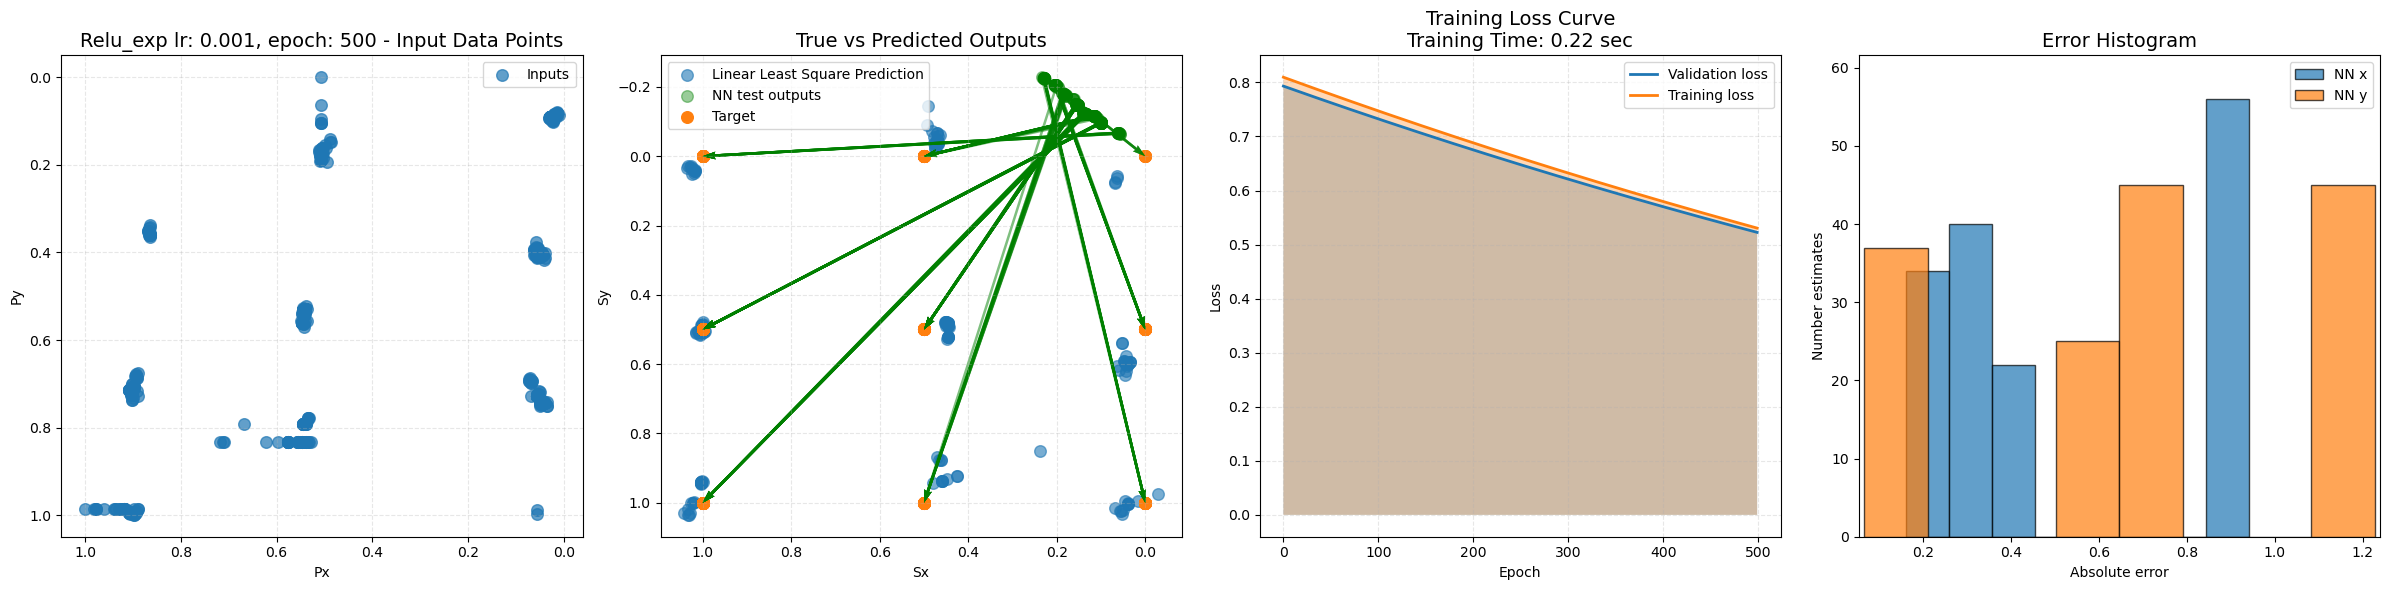

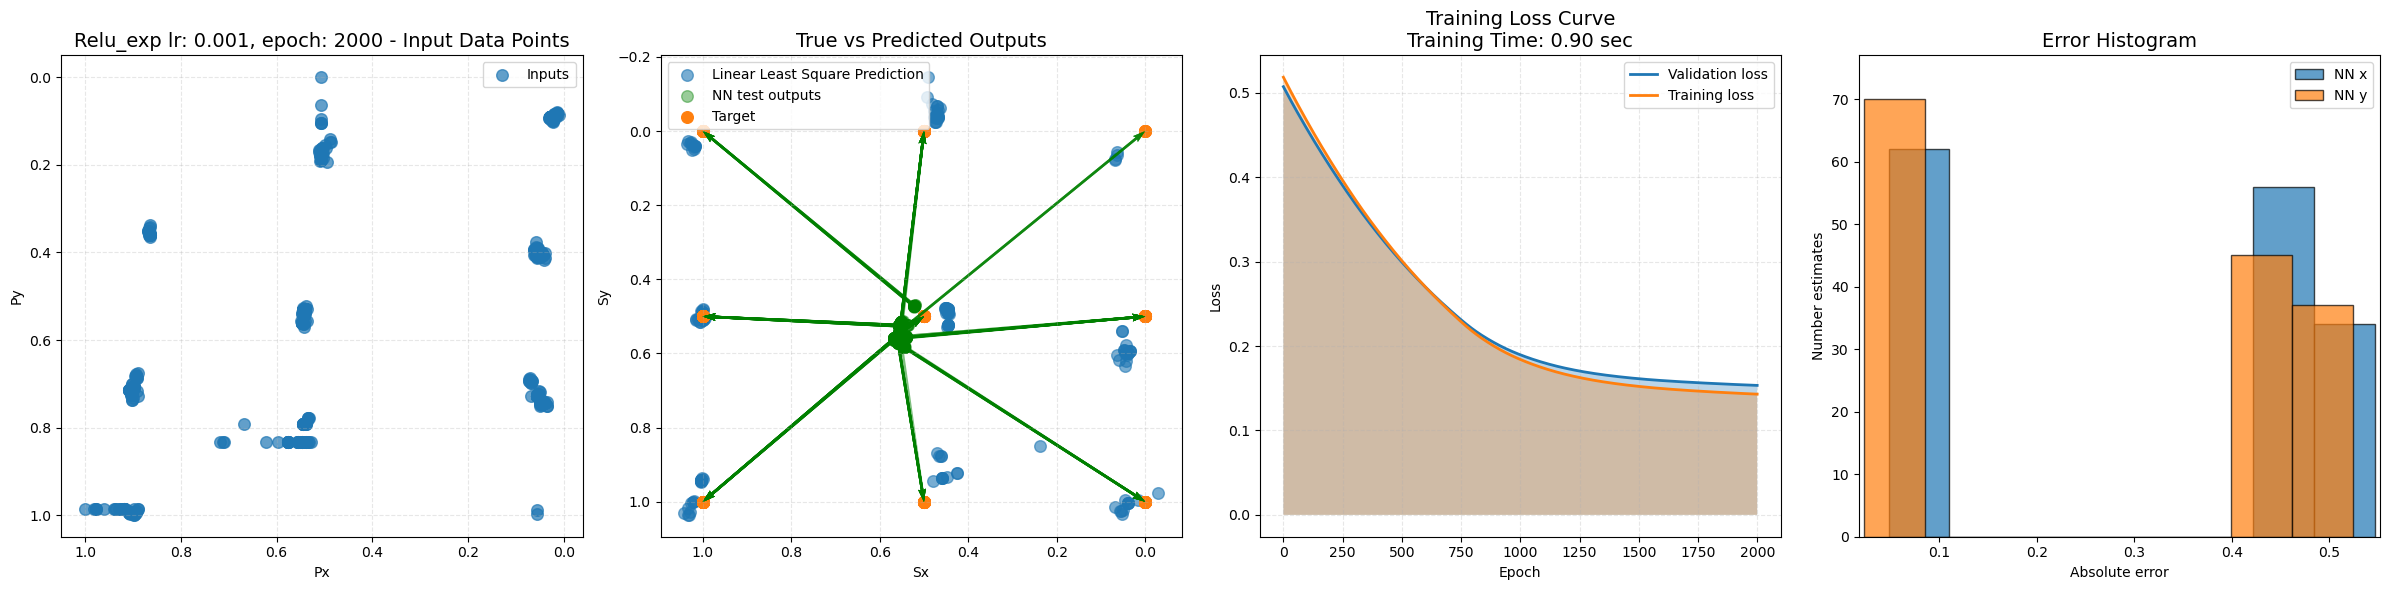

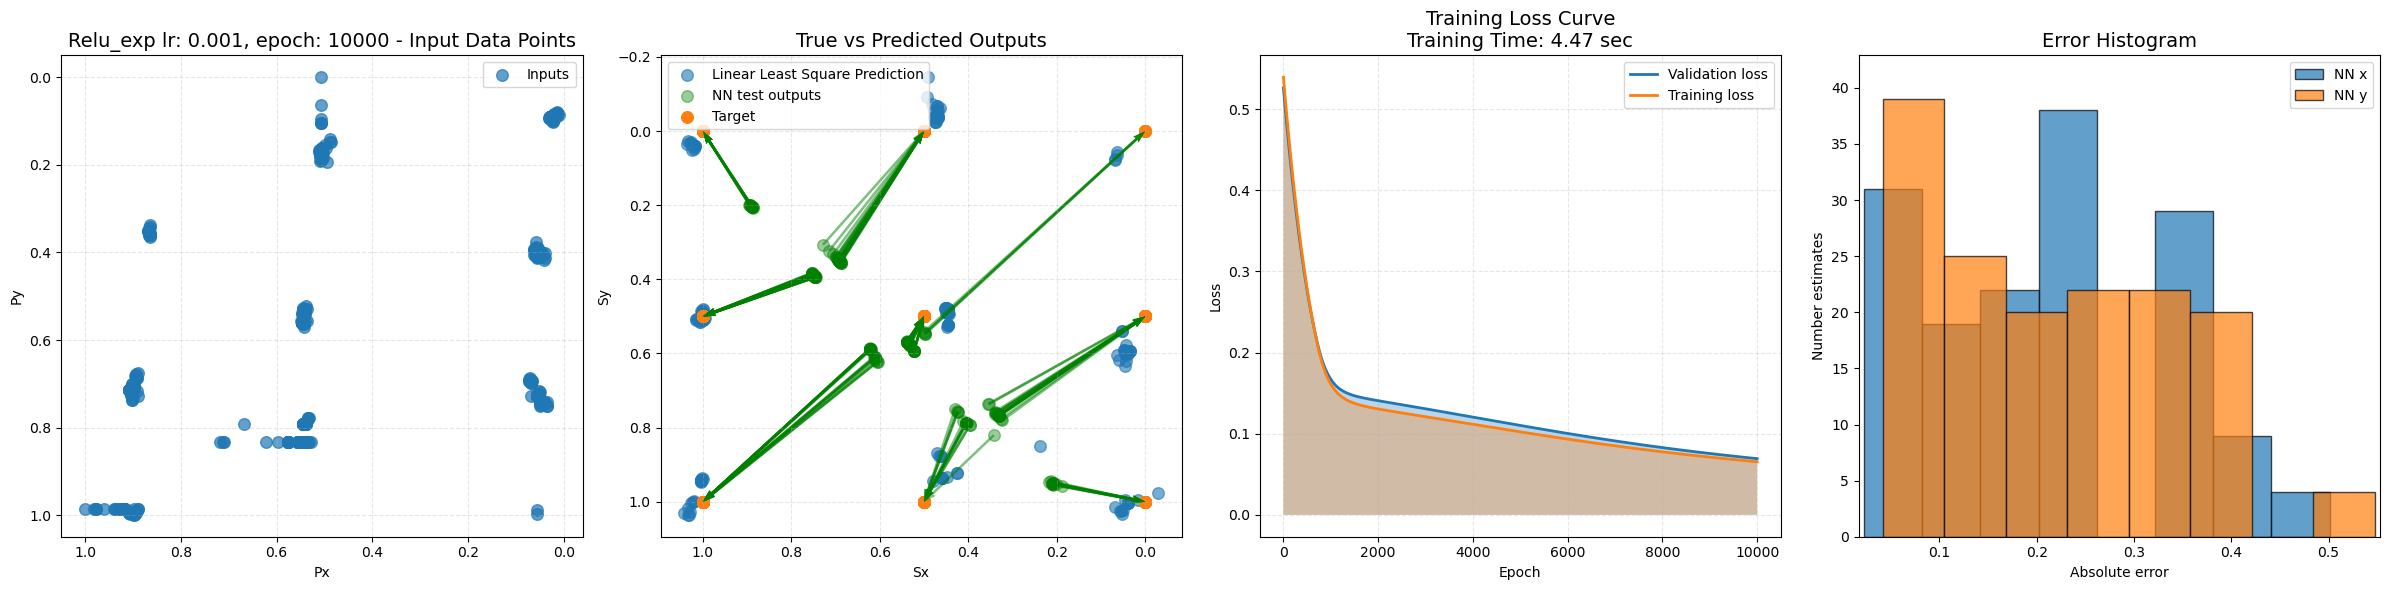

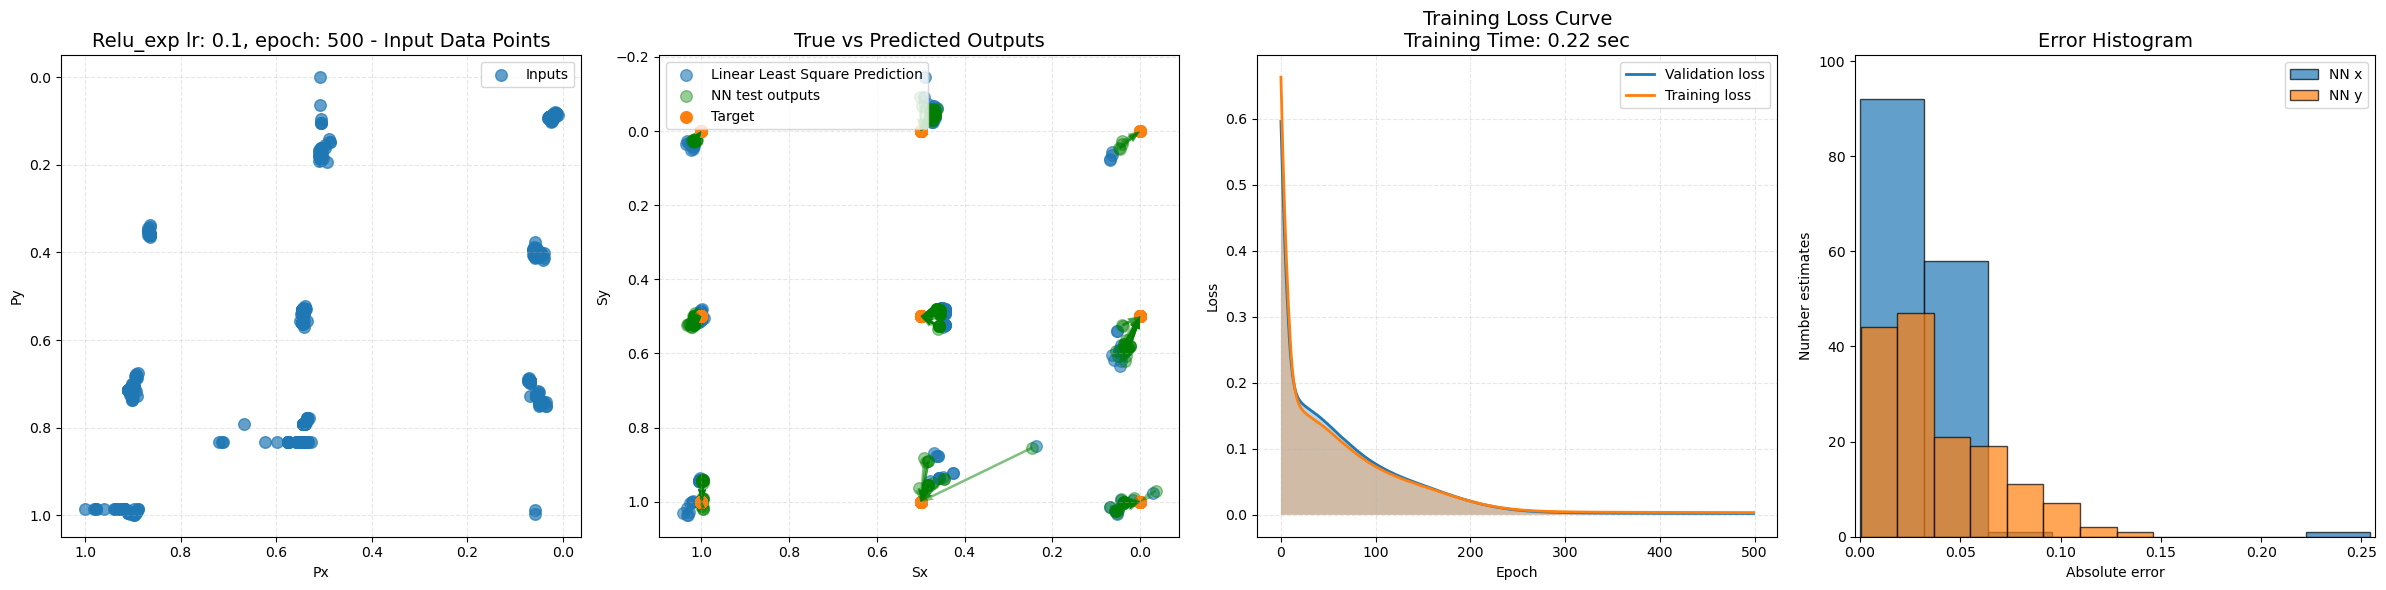

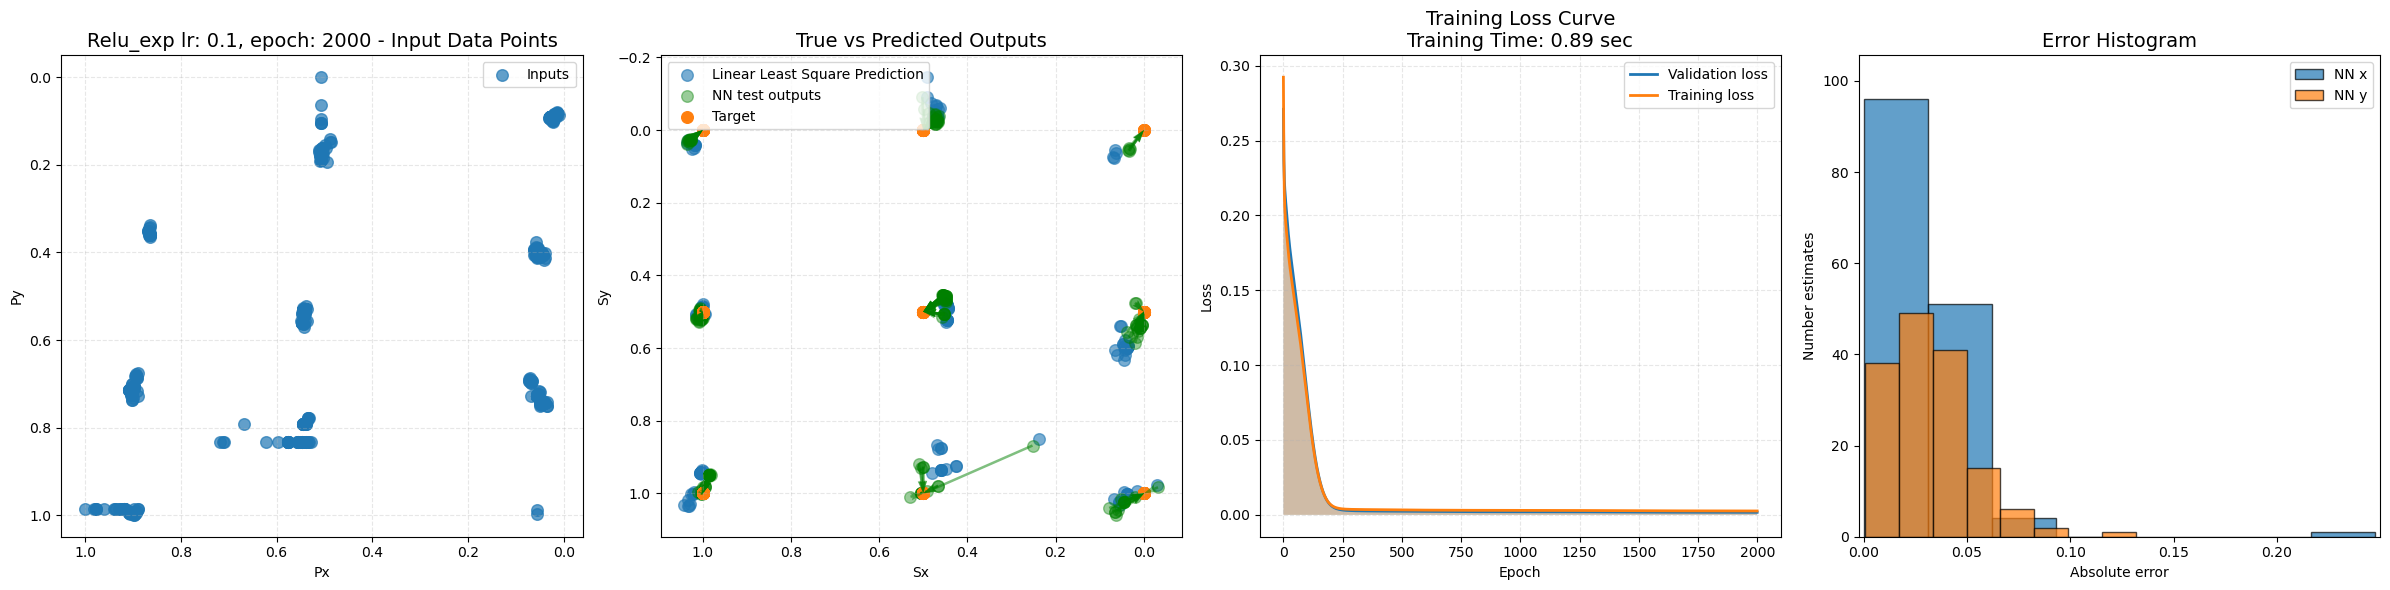

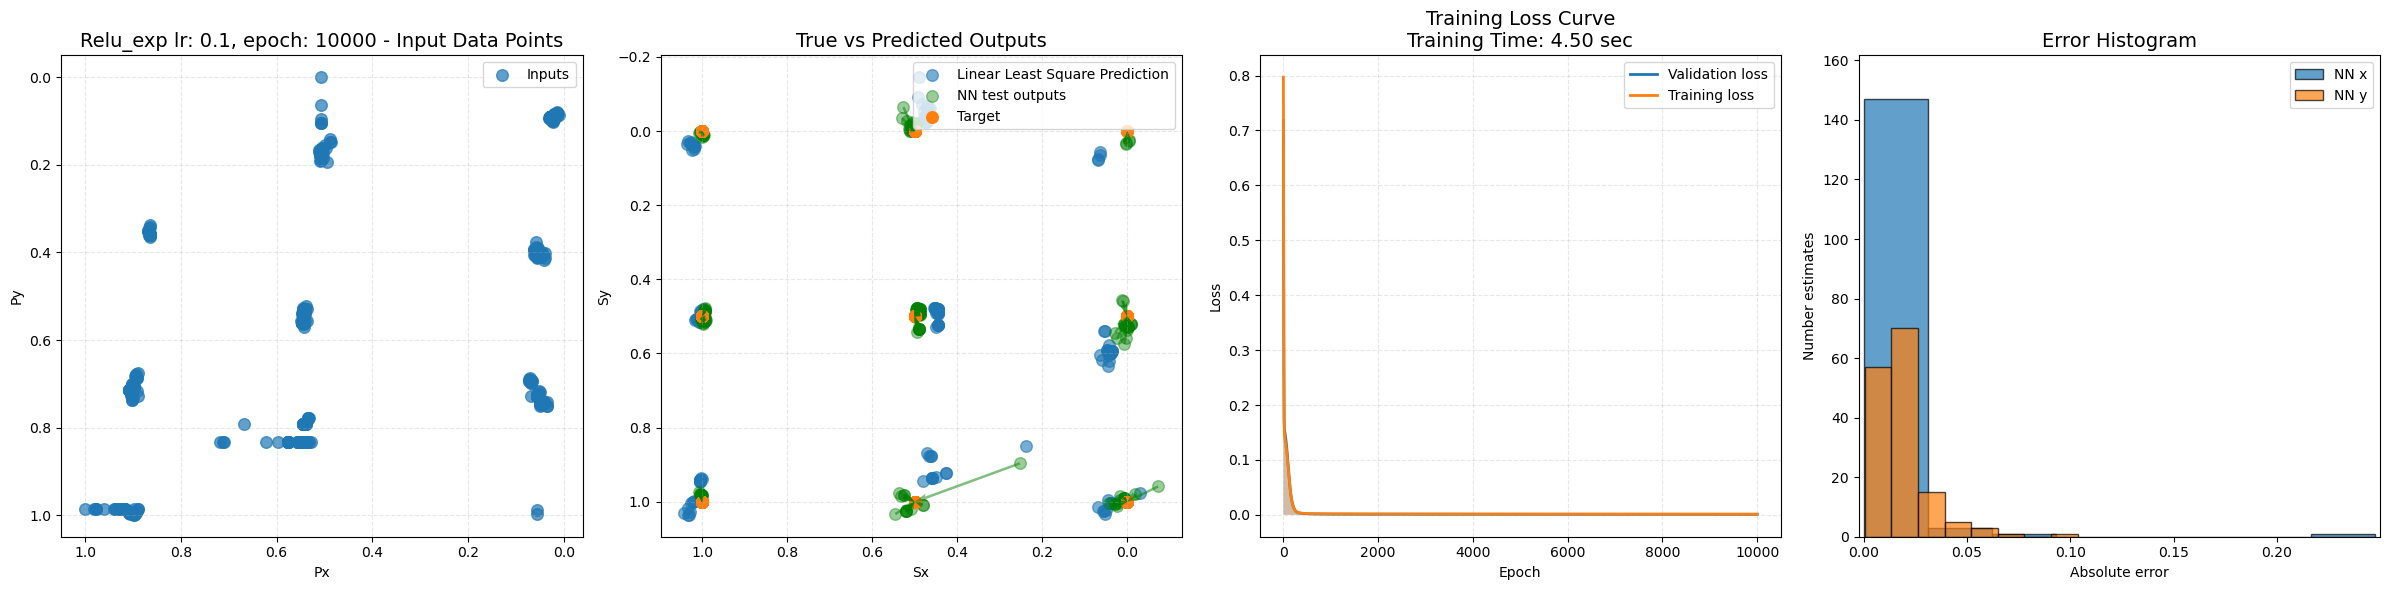

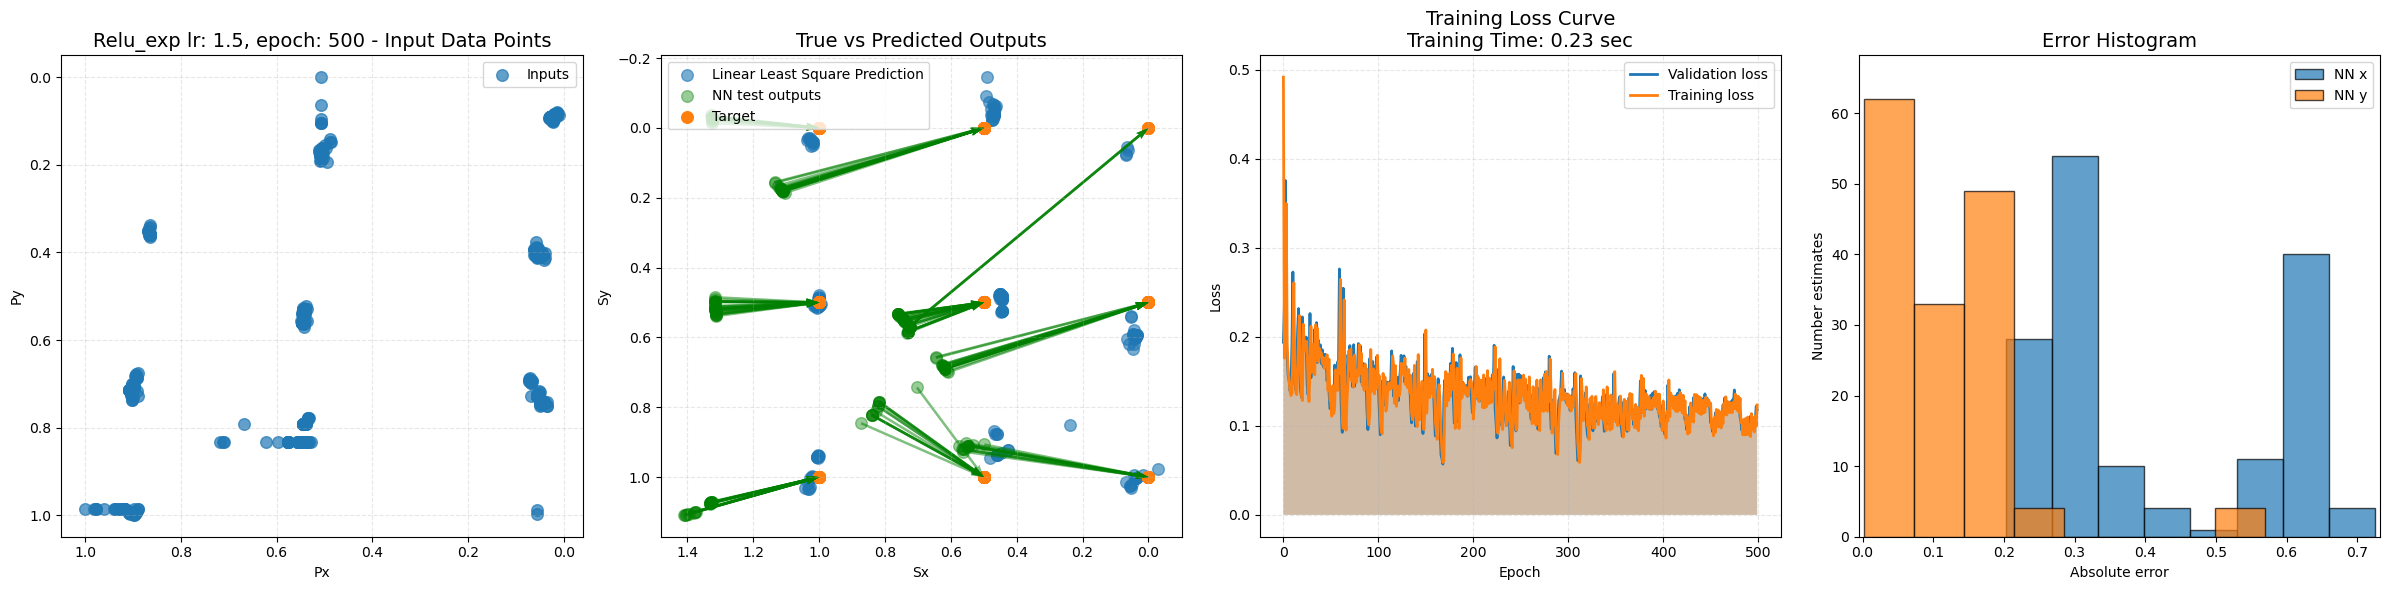

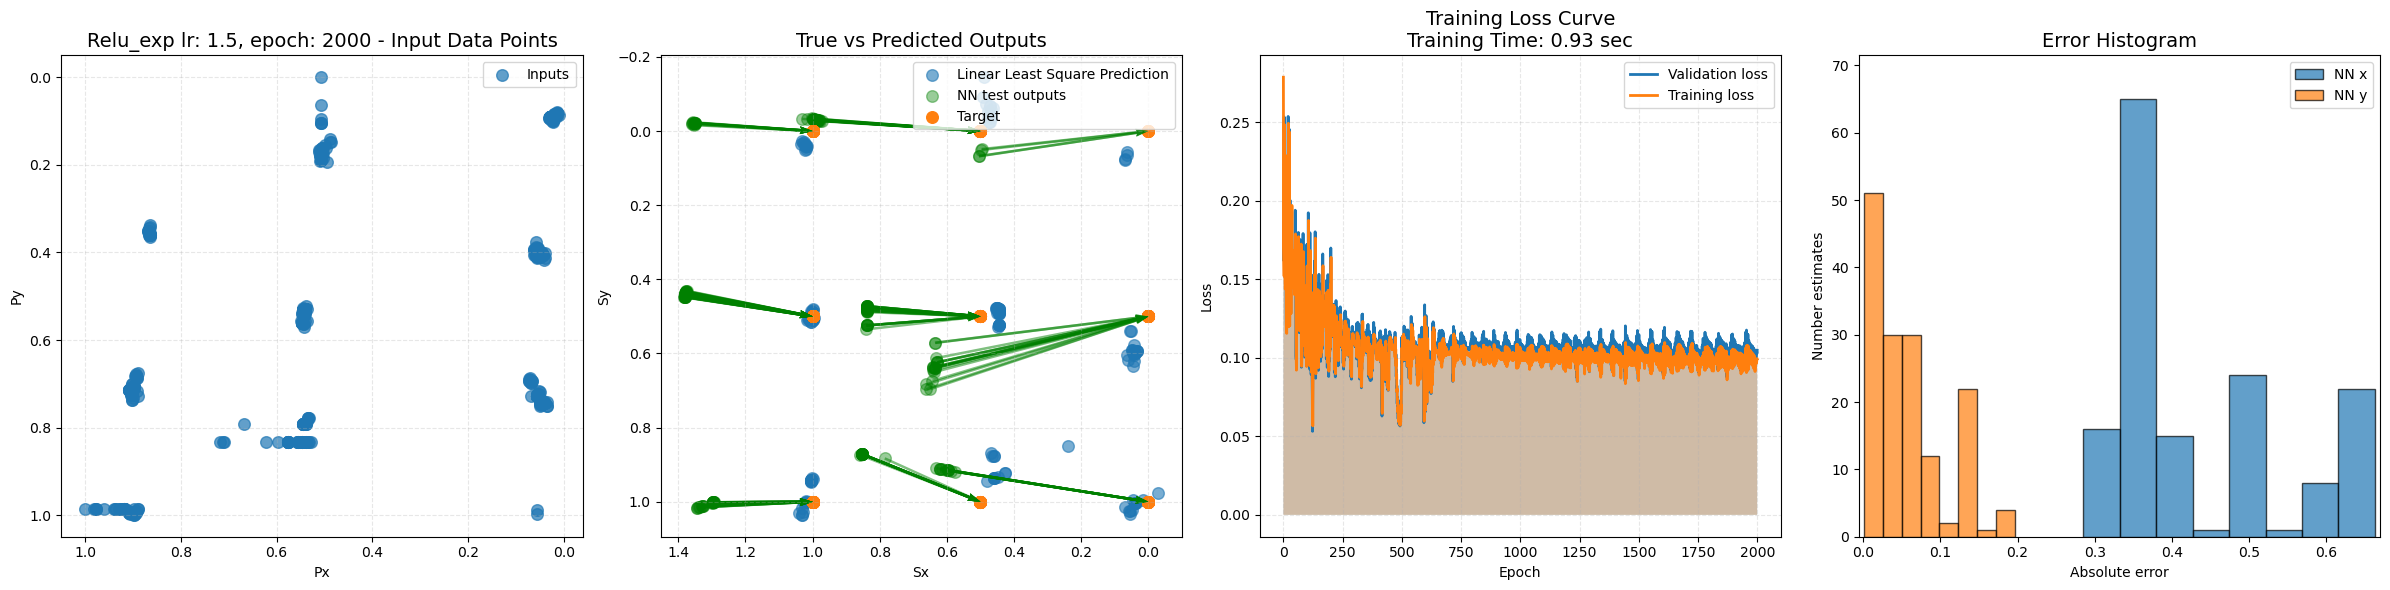

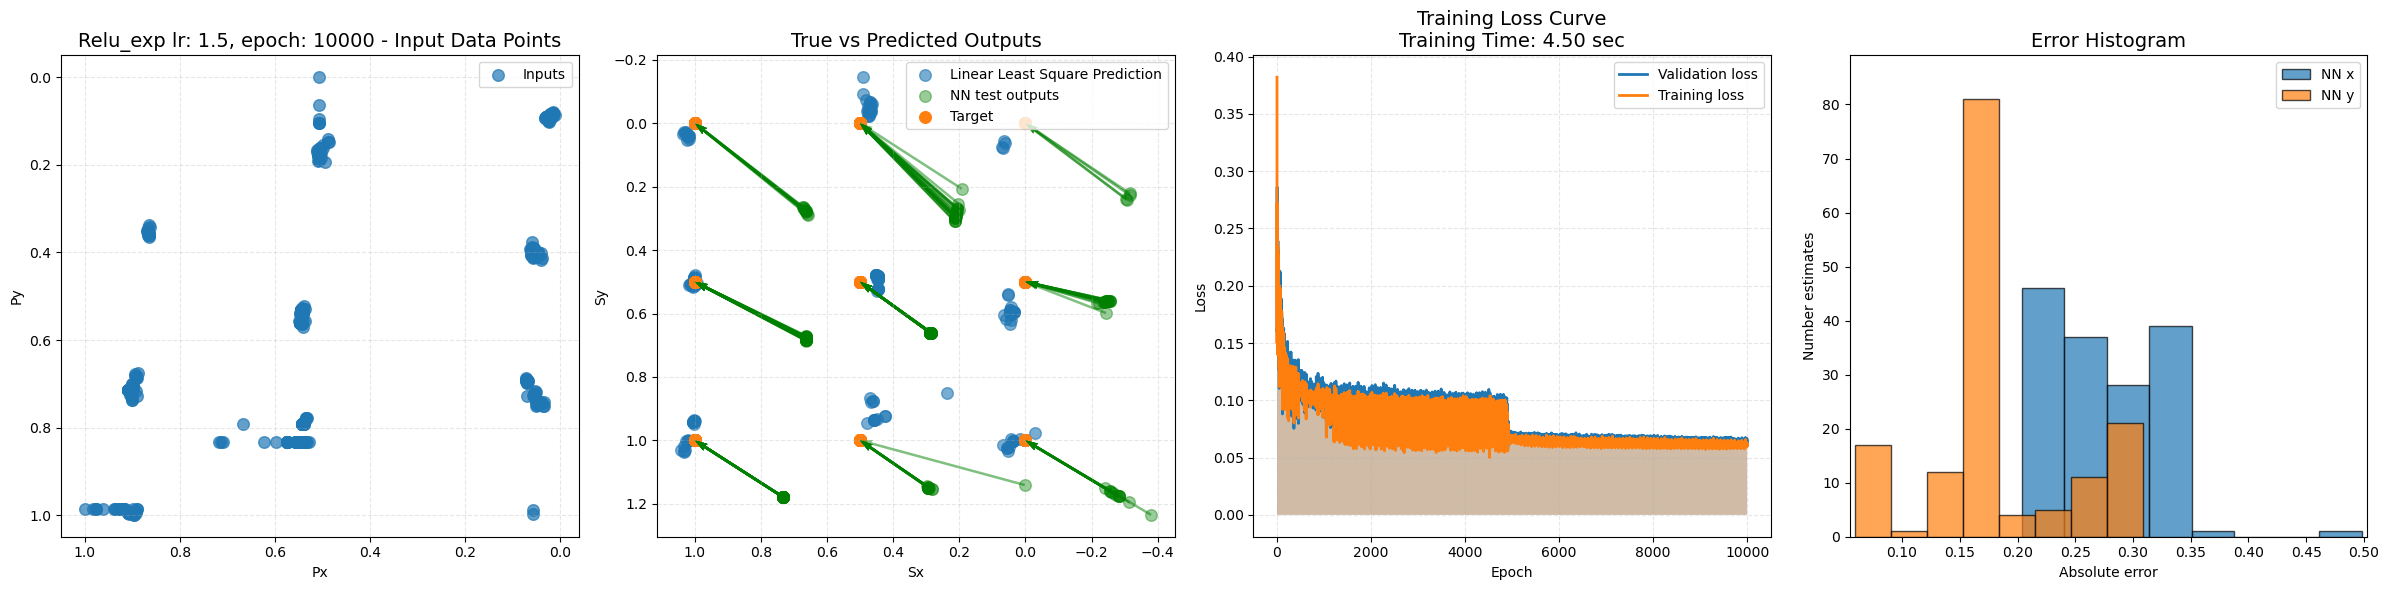

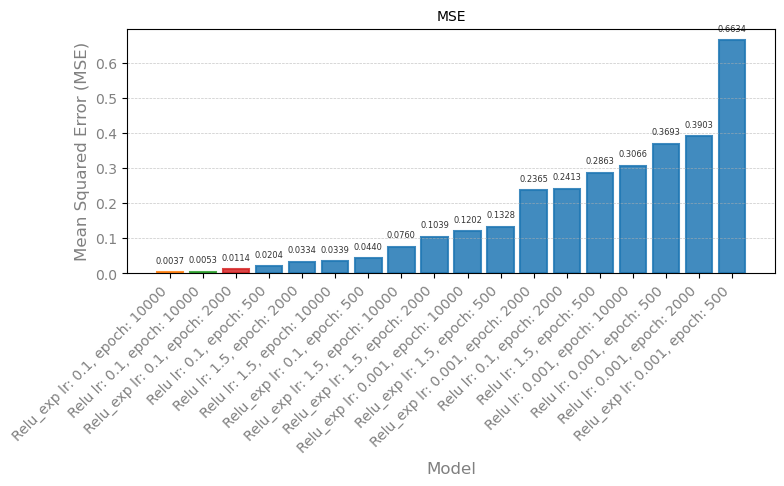

In [145]:
import torch
from torch.nn import MSELoss
from torch.optim import SGD
import nn_util

# Define the non-linear models
class LinearModelRelu(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearModelRelu, self).__init__()
        self.linear1 = torch.nn.Linear(input_dim, output_dim)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        return x

class LinearModelRelu_exp(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LinearModelRelu_exp, self).__init__()
        self.linear1 = torch.nn.Linear(input_dim, hidden_dim)
        self.relu1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.linear3(x)
        return x

# Set hyperparameters
input_dim = 2
output_dim = 2
learning_rate = [0.001, 0.1, 1.5]
epoch = [500, 2000, 10000]
hidden_layer = 10

criterion = MSELoss()

# Containers for non-linear model results
models_dict_arc_relu = {}
losses_dict_arc_relu = {}
losses_val_dict_arc_relu = {}
training_time_dict_arc_relu = {}
pred_norm_arc_relu = {}
errors_norm_arc_relu = {}

models_dict_arc_relu_exp = {}
losses_dict_arc_relu_exp = {}
losses_val_dict_arc_relu_exp = {}
training_time_dict_arc_relu_exp = {}
pred_norm_arc_relu_exp = {}
errors_norm_arc_relu_exp = {}

# Load and normalize cleaned data
scaler_cleaned = DataScaler()
X_cleaned = scaler_cleaned.normalize(nn_util.load_from_csv('data/cleaned_pupils.csv'))
Y_cleaned = scaler_cleaned.normalize(nn_util.load_from_csv('data/cleaned_screen_coordinates.csv'))

# Split data
X_train_cl, X_test_cl, Y_train_cl, Y_test_cl = train_test_split(X_cleaned, Y_cleaned, test_size=0.2, random_state=42)
X_train_cl, X_val_cl, Y_train_cl, Y_val_cl = train_test_split(X_train_cl, Y_train_cl, test_size=0.25, random_state=42)

# Convert data to tensors
X_train_tensor_cl = torch.tensor(X_train_cl, dtype=torch.float32)
Y_train_tensor_cl = torch.tensor(Y_train_cl, dtype=torch.float32)
X_test_tensor_cl = torch.tensor(X_test_cl, dtype=torch.float32)
Y_test_tensor_cl = torch.tensor(Y_test_cl, dtype=torch.float32)
X_val_tensor_cl = torch.tensor(X_val_cl, dtype=torch.float32)
Y_val_tensor_cl = torch.tensor(Y_val_cl, dtype=torch.float32)

# Training loop for both non-linear models
for lr in learning_rate:
    for epochs in epoch:
        # Train and evaluate LinearModelRelu
        model_relu = LinearModelRelu(input_dim, output_dim)
        optimizer_relu = SGD(model_relu.parameters(), lr=lr)
        losses_relu, val_losses_relu, training_time_relu = train_model(
            model_relu, criterion, optimizer_relu, X_train_tensor_cl, Y_train_tensor_cl,
            X_val_tensor_cl, Y_val_tensor_cl, num_epochs=epochs
        )
        mse_relu, pred_relu, true_relu, errors_relu = test_model(model_relu, X_test_tensor_cl, Y_test_tensor_cl)

        # Save results for LinearModelRelu
        key_relu = f"Relu lr: {lr}, epoch: {epochs}"
        models_dict_arc_relu[key_relu] = model_relu
        losses_dict_arc_relu[key_relu] = losses_relu
        losses_val_dict_arc_relu[key_relu] = val_losses_relu
        training_time_dict_arc_relu[key_relu] = training_time_relu
        pred_norm_arc_relu[key_relu] = pred_relu
        errors_norm_arc_relu[key_relu] = errors_relu

        # Train and evaluate LinearModelRelu_exp
        model_relu_exp = LinearModelRelu_exp(input_dim, hidden_layer, output_dim)
        optimizer_relu_exp = SGD(model_relu_exp.parameters(), lr=lr)
        losses_relu_exp, val_losses_relu_exp, training_time_relu_exp = train_model(
            model_relu_exp, criterion, optimizer_relu_exp, X_train_tensor_cl, Y_train_tensor_cl,
            X_val_tensor_cl, Y_val_tensor_cl, num_epochs=epochs
        )
        mse_relu_exp, pred_relu_exp, true_relu_exp, errors_relu_exp = test_model(model_relu_exp, X_test_tensor_cl, Y_test_tensor_cl)

        # Save results for LinearModelRelu_exp
        key_relu_exp = f"Relu_exp lr: {lr}, epoch: {epochs}"
        models_dict_arc_relu_exp[key_relu_exp] = model_relu_exp
        losses_dict_arc_relu_exp[key_relu_exp] = losses_relu_exp
        losses_val_dict_arc_relu_exp[key_relu_exp] = val_losses_relu_exp
        training_time_dict_arc_relu_exp[key_relu_exp] = training_time_relu_exp
        pred_norm_arc_relu_exp[key_relu_exp] = pred_relu_exp
        errors_norm_arc_relu_exp[key_relu_exp] = errors_relu_exp

# Visualize results using collected data
nn_util.plot_results_collected(
    X_cleaned, 
    X_train_tensor_cl, Y_train_tensor_cl, 
    X_test_tensor_cl, Y_test_tensor_cl, 
    pred_norm_arc_relu, errors_norm_arc_relu, 
    models_dict_arc_relu, 
    losses_dict_arc_relu, 
    losses_val_dict_arc_relu, 
    training_time_dict_arc_relu
)

nn_util.plot_results_collected(
    X_cleaned, 
    X_train_tensor_cl, Y_train_tensor_cl, 
    X_test_tensor_cl, Y_test_tensor_cl, 
    pred_norm_arc_relu_exp, errors_norm_arc_relu_exp, 
    models_dict_arc_relu_exp, 
    losses_dict_arc_relu_exp, 
    losses_val_dict_arc_relu_exp, 
    training_time_dict_arc_relu_exp
)

# Plot MSE comparison
# Compute scalar MSE values for each model in the dictionaries
mse_dict_arc_relu = {key: np.mean(val) for key, val in losses_dict_arc_relu.items()}
mse_dict_arc_relu_exp = {key: np.mean(val) for key, val in losses_dict_arc_relu_exp.items()}

# Combine the dictionaries for comparison
combined_mse_dict = {**mse_dict_arc_relu, **mse_dict_arc_relu_exp}

# Plot MSE comparison
nn_util.plot_mse_bar(combined_mse_dict)




---
**Task 17 (easy): Reflect on the results💡**
1. Do more/less complex models improve the result? Why/why not?
2. Are there indications of overfitting in any of the models?


---

## See task 18 for answer to task 17


---
**Task 18 (easy): Analyse results💡**
1. Experiment with other architectures by suggesting models with different number layers and neurons in each layer.
**Note:** This part of the exercise can easily become a timesink, mind your time as you proceed.


2. Reflect on the results    - Do more/less complex models improve the result? Why/why not?
    - Do any of the models show signs of overfitting?




---

Model: 1 Hidden Layer (10 Neurons) lr: 0.001, epoch: 500
 - MSE: 0.4878
 - Training Time: 0.19s
 - Final Training Loss: 0.5343
 - Final Validation Loss: 0.5266

Model: 1 Hidden Layer (10 Neurons) lr: 0.001, epoch: 2000
 - MSE: 0.0803
 - Training Time: 0.72s
 - Final Training Loss: 0.0884
 - Final Validation Loss: 0.0938

Model: 1 Hidden Layer (10 Neurons) lr: 0.001, epoch: 10000
 - MSE: 0.0299
 - Training Time: 3.64s
 - Final Training Loss: 0.0357
 - Final Validation Loss: 0.0369

Model: 1 Hidden Layer (10 Neurons) lr: 0.1, epoch: 500
 - MSE: 0.0032
 - Training Time: 0.18s
 - Final Training Loss: 0.0052
 - Final Validation Loss: 0.0039

Model: 1 Hidden Layer (10 Neurons) lr: 0.1, epoch: 2000
 - MSE: 0.0012
 - Training Time: 0.75s
 - Final Training Loss: 0.0031
 - Final Validation Loss: 0.0016

Model: 1 Hidden Layer (10 Neurons) lr: 0.1, epoch: 10000
 - MSE: 0.0010
 - Training Time: 4.14s
 - Final Training Loss: 0.0028
 - Final Validation Loss: 0.0012

Model: 1 Hidden Layer (10 Neurons)

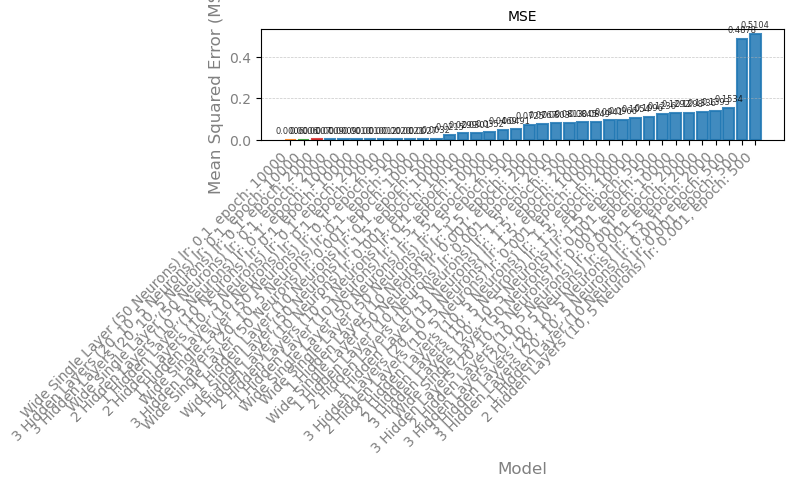

Models with indications of overfitting:
 - 1 Hidden Layer (10 Neurons) lr: 0.001, epoch: 2000
 - 1 Hidden Layer (10 Neurons) lr: 0.001, epoch: 10000
 - 1 Hidden Layer (10 Neurons) lr: 1.5, epoch: 2000
 - 1 Hidden Layer (10 Neurons) lr: 1.5, epoch: 10000
 - 2 Hidden Layers (10, 5 Neurons) lr: 0.001, epoch: 2000
 - 2 Hidden Layers (10, 5 Neurons) lr: 0.001, epoch: 10000
 - 2 Hidden Layers (10, 5 Neurons) lr: 0.1, epoch: 500
 - 2 Hidden Layers (10, 5 Neurons) lr: 1.5, epoch: 10000
 - 3 Hidden Layers (20, 10, 5 Neurons) lr: 0.001, epoch: 500
 - 3 Hidden Layers (20, 10, 5 Neurons) lr: 0.001, epoch: 2000
 - 3 Hidden Layers (20, 10, 5 Neurons) lr: 0.001, epoch: 10000
 - 3 Hidden Layers (20, 10, 5 Neurons) lr: 1.5, epoch: 2000
 - 3 Hidden Layers (20, 10, 5 Neurons) lr: 1.5, epoch: 10000
 - Wide Single Layer (50 Neurons) lr: 0.001, epoch: 500
 - Wide Single Layer (50 Neurons) lr: 0.001, epoch: 2000
 - Wide Single Layer (50 Neurons) lr: 1.5, epoch: 10000

Reflection on Complexity:
Model: 1 Hidde

In [148]:
import torch
from torch.nn import MSELoss
from torch.optim import SGD
import nn_util

# Define additional architectures
class LinearModelRelu_Custom(torch.nn.Module):
    def __init__(self, input_dim, layers_config, output_dim):
        """
        A customizable fully connected network with ReLU activation.
        Args:
            input_dim (int): Number of input features.
            layers_config (list[int]): Number of neurons in each hidden layer.
            output_dim (int): Number of output features.
        """
        super(LinearModelRelu_Custom, self).__init__()
        layers = []
        in_dim = input_dim
        for out_dim in layers_config:
            layers.append(torch.nn.Linear(in_dim, out_dim))
            layers.append(torch.nn.ReLU())
            in_dim = out_dim
        layers.append(torch.nn.Linear(in_dim, output_dim))
        self.net = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# Function to train and test custom architectures
def train_and_evaluate_architectures(X_train, Y_train, X_val, Y_val, X_test, Y_test, architectures, learning_rate, epochs):
    results = {}
    for architecture_name, architecture in architectures.items():
        for lr in learning_rate:
            for epoch in epochs:
                # Initialize model and optimizer
                model = architecture()
                optimizer = SGD(model.parameters(), lr=lr)
                
                # Train model
                losses, val_losses, training_time = train_model(
                    model, criterion, optimizer, X_train, Y_train, X_val, Y_val, num_epochs=epoch
                )
                
                # Test model
                mse, predictions, true_values, errors = test_model(model, X_test, Y_test)
                
                # Save results
                key = f"{architecture_name} lr: {lr}, epoch: {epoch}"
                results[key] = {
                    "model": model,
                    "losses": losses,
                    "val_losses": val_losses,
                    "training_time": training_time,
                    "predictions": predictions,
                    "errors": errors,
                    "mse": mse
                }
    return results

# Experiment with various architectures
architectures = {
    "1 Hidden Layer (10 Neurons)": lambda: LinearModelRelu_Custom(input_dim, [10], output_dim),
    "2 Hidden Layers (10, 5 Neurons)": lambda: LinearModelRelu_Custom(input_dim, [10, 5], output_dim),
    "3 Hidden Layers (20, 10, 5 Neurons)": lambda: LinearModelRelu_Custom(input_dim, [20, 10, 5], output_dim),
    "Wide Single Layer (50 Neurons)": lambda: LinearModelRelu_Custom(input_dim, [50], output_dim),
}

# Set parameters
learning_rate = [0.001, 0.1, 1.5]
epochs = [500, 2000, 10000]
criterion = MSELoss()

# Train and test architectures
results = train_and_evaluate_architectures(
    X_train_tensor_cl, Y_train_tensor_cl,
    X_val_tensor_cl, Y_val_tensor_cl,
    X_test_tensor_cl, Y_test_tensor_cl,
    architectures, learning_rate, epochs
)

# Analyze results
for key, result in results.items():
    print(f"Model: {key}")
    print(f" - MSE: {result['mse']:.4f}")
    print(f" - Training Time: {result['training_time']:.2f}s")
    print(f" - Final Training Loss: {result['losses'][-1]:.4f}")
    print(f" - Final Validation Loss: {result['val_losses'][-1]:.4f}")
    print("")

# Visualize results
mse_dict = {key: result["mse"] for key, result in results.items()}
nn_util.plot_mse_bar(mse_dict)

# Reflections on results
# Task 17: Overfitting Analysis
overfitting_models = [
    key for key, result in results.items()
    if result["val_losses"][-1] > result["losses"][-1]
]
print("Models with indications of overfitting:")
for model in overfitting_models:
    print(f" - {model}")

# Task 18: Reflection on Model Complexity
print("\nReflection on Complexity:")
for key, result in results.items():
    print(f"Model: {key}")
    print(f" - Final MSE: {result['mse']:.4f}")
    print(f" - Complexity: {architectures[key.split(' lr')[0]].__doc__}")
    print("")


## Own dataset
You are now encouraged to experiment with your own dataset and other models. 
**Note:** For the exam it may be convenient to copy your code from task [Task 10](#prediction100) to the cell below.
This part of the exercise can easily become a timesink, mind your time as you proceed.


---
**Task 19 (easy): Train models (own dataset)👩‍💻💡**
1. Experiment with your own cleaned dataset from the exercise Filtering gaze data
. 
2. Reflect on your results, compare to the results of `test_subject_3`
. 


---